In [1]:
import statistics
import os
import sys
import seaborn as sns
import collections as col
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Union
from pathlib import Path
import gseapy as gp
import functions_sheet as myfunc
from gseapy import barplot, dotplot
import re
import upsetplot as usp
from collections import Counter
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
from gseapy import Msigdb
from gseapy import GSEA
from scipy.cluster.hierarchy import linkage

path_to_main_comparison_dir = "/nfs/data3/IHEC/TF_PRIO/comparisons/cells"
path_to_all_tfs_file = "/nfs/data3/IHEC/TF_PRIO/additional_files/all_tfs.txt"
path_to_figure_folder = "/nfs/data3/IHEC/TF_PRIO/created_plots/6_celltype_specific_TFs"

Reading out TFs

In [2]:
tf_overlap_df_tpm = myfunc.create_overlap_df_with_tpm(path_to_main_comparison_dir, tpm_filter=1)
tf_overlap_df_tpm = myfunc.add_overlap_union_unique_shared_with_all_or_once(tf_overlap_df_tpm)

create dataframe with TFs that are TOP TF in all comparison in which a specific celltype was used

In [3]:
cell_types = ["b-cells-healthy", "macrophage-healthy", "t-cell-healthy",  "monocyte-healthy", "neutrophil-healthy"]
df_cell_type_tfs = pd.DataFrame(columns=["active_marks", "suppressive_marks"])
for cell_type in cell_types:
    

    tf_active_all_shared = tf_overlap_df_tpm[tf_overlap_df_tpm.index.str.contains(cell_type)
    & ~tf_overlap_df_tpm.index.str.contains("b-cells-leukemia")]["active_marks"].to_list()
    cell_type_specific_TFs_active = set.intersection(*tf_active_all_shared)

    tf_suppressive_all_shared = tf_overlap_df_tpm[tf_overlap_df_tpm.index.str.contains(cell_type)
    & ~tf_overlap_df_tpm.index.str.contains("b-cells-leukemia")]["suppressive_marks"].to_list()
    cell_type_specific_TFs_suppressive = set.intersection(*tf_suppressive_all_shared)


    df_cell_type_tfs.loc[cell_type] = [cell_type_specific_TFs_active, cell_type_specific_TFs_suppressive]

In [4]:
df_cell_type_tfs

active_marks  \
b-cells-healthy     {RELA, JUN, FOSL2, ZBTB6, VEZF1, YY1, KLF3, MG...   
macrophage-healthy                   {VEZF1, MGA, RBPJ, FOXO3, PRDM4}   
t-cell-healthy      {STAT3, JUN, STAT5B, FOSL2, RBPJ, SP4, KLF7, Z...   
monocyte-healthy    {RELA, SREBF1, ZNF770, ZNF121, KLF6, NFATC3, I...   
neutrophil-healthy  {ZNF148, ELK4, RELA, ZBTB48, ZNF354C, ZNF263, ...   

                                                suppressive_marks  
b-cells-healthy     {KLF8, ZNF354C, ZBED2, NR4A1, SREBF2, NFATC2}  
macrophage-healthy                                   {CBFB, RELB}  
t-cell-healthy                                   {NFE2L1, ARID5B}  
monocyte-healthy                                               {}  
neutrophil-healthy                               {NFE2L1, ZNF384}

In [5]:
df_cell_type_tfs.applymap(lambda x: len(x))


active_marks  suppressive_marks
b-cells-healthy                9                  6
macrophage-healthy             5                  2
t-cell-healthy                10                  2
monocyte-healthy               7                  0
neutrophil-healthy            19                  2

# Filter TFs
Filter out TFs which:
- have a TPM under 1 in the celltype to which they are accounted
- are generic TFs

## Filter out generic TFs

In [4]:
generic_TFs_active, generic_TFs_suppressive = myfunc.read_out_generic_TFs(tf_overlap_df_tpm, 9)

In [8]:
generic_TFs_active

['MGA', 'RELA', 'RBPJ', 'FOSL2', 'JUN']

In [8]:
generic_TFs_suppressive

[]

no removal of generic suppressive TFs because there are none

In [5]:
df_cell_type_tfs["active_marks"] = df_cell_type_tfs["active_marks"].apply(lambda x: {tf for tf in x if tf not in generic_TFs_active})

In [6]:
df_cell_type_tfs.applymap(lambda x: len(x))

active_marks  suppressive_marks
b-cells-healthy                5                  6
macrophage-healthy             3                  2
t-cell-healthy                 7                  2
monocyte-healthy               6                  0
neutrophil-healthy            16                  2

## Filter out TFs with TPM >= 1 not in the specific celltype
If a TF appeared as TF in all comparisons from celltype X with any other used celltype, it can be the case that this TF is in the resulting celltype specific table because the TPM value was over 1 for all the other celltypes but not celltype X (as the TPM filtering for a comparison just checks if a TF in a comparison is over 1 for one of the two used conditions/celltypes)

In [6]:
tpm_df = myfunc.get_tpm_filtered_genes_df(path_to_main_comparison_dir, tpm_filter=1)
tpm_df["length"] = tpm_df["TPM_filtered_genes"].apply(lambda x: len(x))
tpm_df

TPM_filtered_genes  length
celltype                                                                     
neutrophil-healthy  {ASH2L, TERF2, IRAK3, LMO2, NAP1L4, ATP2B4, RP...    7211
macrophage-healthy  {ASH2L, TERF2, IRAK3, LMO2, NAP1L4, ATP2B4, RP...    9715
monocyte-healthy    {ASH2L, TERF2, IRAK3, LMO2, NAP1L4, ATP2B4, RP...   10447
b-cells-healthy     {ASH2L, TERF2, VDAC1P9, ZNF773, IRAK3, LMO2, N...   11091
t-cell-healthy      {ASH2L, TERF2, ZNF773, NAP1L4, ATP2B4, RPL32P3...   10170
b-cells-leukemia    {ASH2L, TERF2, AL603839.4, VDAC1P9, ZNF773, IR...   14447

In [7]:
df_cell_type_tfs['active_marks'] = df_cell_type_tfs.apply(lambda row: {tf for tf in row["active_marks"] if all(tpm_gene in tpm_df.loc[row.name, "TPM_filtered_genes"] for tpm_gene in tf.split("::"))},axis=1)
df_cell_type_tfs['suppressive_marks'] = df_cell_type_tfs.apply(lambda row: {tf for tf in row["suppressive_marks"] if all(tpm_gene in tpm_df.loc[row.name, "TPM_filtered_genes"] for tpm_gene in tf.split("::"))},axis=1)
df_cell_type_tfs.applymap(lambda x: len(x))

active_marks  suppressive_marks
b-cells-healthy                5                  6
macrophage-healthy             2                  2
t-cell-healthy                 7                  2
monocyte-healthy               6                  0
neutrophil-healthy            13                  2

In [143]:
df_cell_type_tfs

active_marks  \
b-cells-healthy                      {VEZF1, NR2C1, KLF3, YY1, ZBTB6}   
macrophage-healthy                                     {PRDM4, VEZF1}   
t-cell-healthy      {NFATC3, SP4, STAT5B, KLF7, STAT3, ZNF554, ZNF...   
monocyte-healthy         {NFATC3, ZNF121, KLF6, ZNF770, IRF2, SREBF1}   
neutrophil-healthy  {MAZ, KLF6, ZEB1, ARNT::HIF1A, FOXJ2, ZNF148, ...   

                                                suppressive_marks  
b-cells-healthy     {KLF8, SREBF2, ZNF354C, NR4A1, ZBED2, NFATC2}  
macrophage-healthy                                   {CBFB, RELB}  
t-cell-healthy                                   {NFE2L1, ARID5B}  
monocyte-healthy                                               {}  
neutrophil-healthy                               {NFE2L1, ZNF384}

In [17]:
df_cell_type_tfs.at["neutrophil-healthy", "active_marks"]

{'ARNT::HIF1A',
 'CBFB',
 'ELK4',
 'FOXJ2',
 'KLF6',
 'MAFK',
 'MAZ',
 'ZBTB26',
 'ZBTB48',
 'ZEB1',
 'ZNF148',
 'ZNF18',
 'ZNF189'}

In [18]:
df_cell_type_tfs.at["t-cell-healthy", "active_marks"]

{'KLF7', 'NFATC3', 'SP4', 'STAT3', 'STAT5B', 'ZNF384', 'ZNF554'}

# literature research on every single TF

**B-cells**:
- active markers:
    - YY1:
        - YY1 Is Required for Germinal Center B Cell Development https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0155311
        - YY1 plays an essential role at all stages of B-cell differentiation https://www.pnas.org/doi/abs/10.1073/pnas.1606297113 

    - (VEZF1)
        - Possible transcription factor. Specifically binds to the CT/GC-rich region of the interleukin-3 promoter and mediates tax transactivation of IL-3 https://www.genecards.org/cgi-bin/carddisp.pl?gene=VEZF1 <br />
            -> IL-3 important for differention of lymphoid/myeloid progenitor cells <br />

    - (RELA (generic TF)) <br /> 
        = RELA Proto-Oncogene, NF-KB Subunit (NF-KB = nuclear factor 'kappa-light-chain-enhancer' of activated B-cells)
        - NF-κB RelA-deficient Lymphocytes: Normal Development of  T Cells and B Cells, Impaired Production of IgA and IgG1 and Reduced Proliferative Responses https://rupress.org/jem/article/185/5/953/7120/NF-B-RelA-deficient-Lymphocytes-Normal-Development <br />
        - Differential requirements for the canonical NF-κB transcription factors c-REL and RELA during the generation and activation of mature B cells https://onlinelibrary.wiley.com/doi/abs/10.1038/icb.2016.95 <br />
        - Regulation of Developing B Cell Survival by RelA-Containing NF-κB Complexes https://journals.aai.org/jimmunol/article/171/8/3963/35767 <br />
    - KLF3
        - Impaired B Cell Development in the Absence of Krüppel-like Factor 3 https://journals.aai.org/jimmunol/article/187/10/5032/85085 
        - Programming of marginal zone B-cell fate by basic Krüppel-like factor (BKLF/KLF3) https://ashpublications.org/blood/article/117/14/3780/20523/Programming-of-marginal-zone-B-cell-fate-by-basic
    - ZBTB6
        - are part of the BTB-ZF transcription factors ->  some of these have also a function for B-cell development
        - therefore this might be a indication that this TF could hold a B-cell related function
        - The BTB-ZF transcription factors https://www.tandfonline.com/doi/abs/10.4161/cc.21277
        - BTB-ZF transcription factors, a growing family of regulators of early and late B-cell development https://onlinelibrary.wiley.com/doi/full/10.1038/icb.2014.20
    - NR2C1
        - nothing found
- suppressive markers:
    - {NR4A1, NFATC2, KLF8, ZNF354C, SREBF2, ZBED2}<br />
    
**Macrophages**:
- active markers:
    - FOXO3
        - FOXO3 Expression in Macrophages Is Lowered by a High-Fat Diet and Regulates Colonic Inflammation and Tumorigenesis https://www.mdpi.com/2218-1989/12/3/250
        - FOXO3-dependent apoptosis limits alcohol-induced liver inflammation by promoting infiltrating macrophage differentiation https://www.nature.com/articles/s41420-017-0020-7?error=cookies_not_supported&code=16c28285-5c91-45a9-97e4-2990c1ad7390
        - FOXO3 Transcription Factor Regulates IL-10 Expression in Mycobacteria-Infected Macrophages, Tuning Their Polarization and the Subsequent Adaptive Immune Response https://www.frontiersin.org/journals/immunology/articles/10.3389/fimmu.2019.02922/full 

    - PRDM4
        - nothing found
    - (VEZF1) -> indirect -  VEZF1 binds (likely) to the promotor of IL-3
        - sources for VEZF1 - IL-3:<br /> 
            https://www.uniprot.org/uniprotkb/Q14119/entry, https://www.sciencedirect.com/science/article/abs/pii/S1769721223000113?via%3Dihub, https://pubmed.ncbi.nlm.nih.gov/8035792/ <br /> 
        - Sources for IL-3 -  macrophage relation:<br /> 
            Regulation of macrophage activation by IL-3 https://journals.aai.org/jimmunol/article-abstract/144/9/3392/110720/Regulation-of-macrophage-activation-by-IL-3-I-IL-3<br /> 
            Macrophage colony‐stimulating factor‐, granulocyte‐macrophage colony‐stimulating factor‐, or IL‐3‐dependent survival of macrophages, but not proliferation https://onlinelibrary.wiley.com/doi/abs/10.1002/eji.200425110
- suppressive markers:
    {ARID5B, JUND, CBFB, RELB}<br />

**T-cell**:
- active  markers:
{KLF7, NFATC3, SP4, STAT3, STAT5B, ZNF384, ZNF554}

SP4 also found by https://academic.oup.com/nar/article/45/1/54/2605711?login=false (https://oup.silverchair-cdn.com/oup/backfile/Content_public/Journal/nar/45/1/10.1093_nar_gkw1061/4/gkw1061_supp.pdf?Expires=1722378959&Signature=waWWqThaMjtqY5iVnIOZyXKGzhEfKc4bg1Lm2w8YWrKohxSJkTf7y8xB7b0HCI4Pa-KjvuPhPo4-JUqxEd8aScPD3j9iQke~tjDyGSW5fovR2Gd5svbcwPjlBMZ6CwLmee~HWoYxLgiqzvAKXWRZvSwrj-9sRAIzuqF2rIkgdpsXz5UpI3SxCFlYFBSo5inKrQ40u9KyLCV7M-P40XVfuERN0TQkcXNoFLODKk8HVh2cZYadIRSluSuF~wnCKedxe5EimlbcfL5vTrsPKV8~Gb4y6Yi9pL18wyUcau3JzWPdh8~pzFhyagQX7BrmHj-STlvc4S~af6Dcr0sGmknmuA__&Key-Pair-Id=APKAIE5G5CRDK6RD3PGA)
- suppressive markers:
{ARID5B, NFE2L1}<br />

**Monocyte**
- active markers:
{ZNF770, SREBF1, ZNF121, NFATC3, KLF6, IRF2}<br />

**Neutrophil**:
- active markers
{ARNT::HIF1A, CBFB, ELK4,FOXJ2, KLF6, MAFK, MAZ, ZBTB26, ZBTB48, ZEB1, ZNF148, ZNF18, ZNF189}
- suppressive markers:
{ZNF384, FOXP1, NFE2L1, FOXJ3}

In [27]:
df_cell_type_tfs

active_markers  \
b-cells-healthy                      {YY1, NR2C1, ZBTB6, KLF3, VEZF1}   
macrophage-healthy                              {FOXO3, PRDM4, VEZF1}   
t-cell-healthy      {ZNF554, STAT3, ZNF384, NFATC3, SP4, KLF7, STA...   
monocyte-healthy         {ZNF770, SREBF1, ZNF121, NFATC3, KLF6, IRF2}   
neutrophil-healthy  {MAFK, ELK4, CBFB, ARNT::HIF1A, ZNF18, KLF6, Z...   

                                              suppressive_markers  
b-cells-healthy     {NR4A1, NFATC2, KLF8, ZNF354C, SREBF2, ZBED2}  
macrophage-healthy                     {ARID5B, JUND, CBFB, RELB}  
t-cell-healthy                                   {ARID5B, NFE2L1}  
monocyte-healthy                                               {}  
neutrophil-healthy                 {ZNF384, FOXP1, NFE2L1, FOXJ3}

# create heatmap based on the celltype specific TFs

In [9]:
mean_expression_df = myfunc.get_expression_df(path_to_main_comparison_dir, modus="mean")

Examine created expression table

In [86]:
mean_expression_df.head()

gene  neutrophil-healthy  macrophage-healthy  monocyte-healthy  \
0    TSPAN6            0.698413           22.640000          0.620321   
1      TNMD            0.026455            0.000001          0.000001   
2      DPM1          954.100529         2128.880000        975.513369   
3     SCYL3         1327.888889          733.400000        825.427807   
4  C1orf112          205.978836          458.240000        321.652406   

   b-cells-healthy  t-cell-healthy  b-cells-leukemia  
0        15.518519       76.796875          2.066667  
1         0.037037        0.020833          0.000001  
2      1299.296296      774.864583       1620.600000  
3      1486.629630     1154.395833       1734.266667  
4      1646.259259      253.307292       1042.866667

replacing the 0s with small values to avoid errors when applying logarithm

In [10]:
mean_expression_df.replace(0, 0.0000001, inplace=True)
mean_expression_df.iloc[:,1:] = np.log2(mean_expression_df.iloc[:,1:])

In [11]:
mean_expression_df.head()

gene  neutrophil-healthy  macrophage-healthy  monocyte-healthy  \
0    TSPAN6           -0.517848            4.500802         -0.688913   
1      TNMD           -5.240314          -23.253497        -23.253497   
2      DPM1            9.897997           11.055879          9.930018   
3     SCYL3           10.374919            9.518456          9.688998   
4  C1orf112            7.686352            8.839960          8.329359   

   b-cells-healthy  t-cell-healthy  b-cells-leukemia  
0         3.955919        6.262976          1.047306  
1        -4.754888       -5.584963        -23.253497  
2        10.343515        9.597800         10.662312  
3        10.537830       10.172922         10.760110  
4        10.684976        7.984745         10.026339

Creating a list of all cell type specific TFs

In [12]:
celltype_specific_tf_set_active = set()
df_cell_type_tfs["active_marks"].apply(lambda x: celltype_specific_tf_set_active.update(x))
celltype_specific_tf_set_suppressive = set()
df_cell_type_tfs["suppressive_marks"].apply(lambda x: celltype_specific_tf_set_suppressive.update(x))


b-cells-healthy       None
macrophage-healthy    None
t-cell-healthy        None
monocyte-healthy      None
neutrophil-healthy    None
Name: suppressive_marks, dtype: object

Creating clustered heatmaps

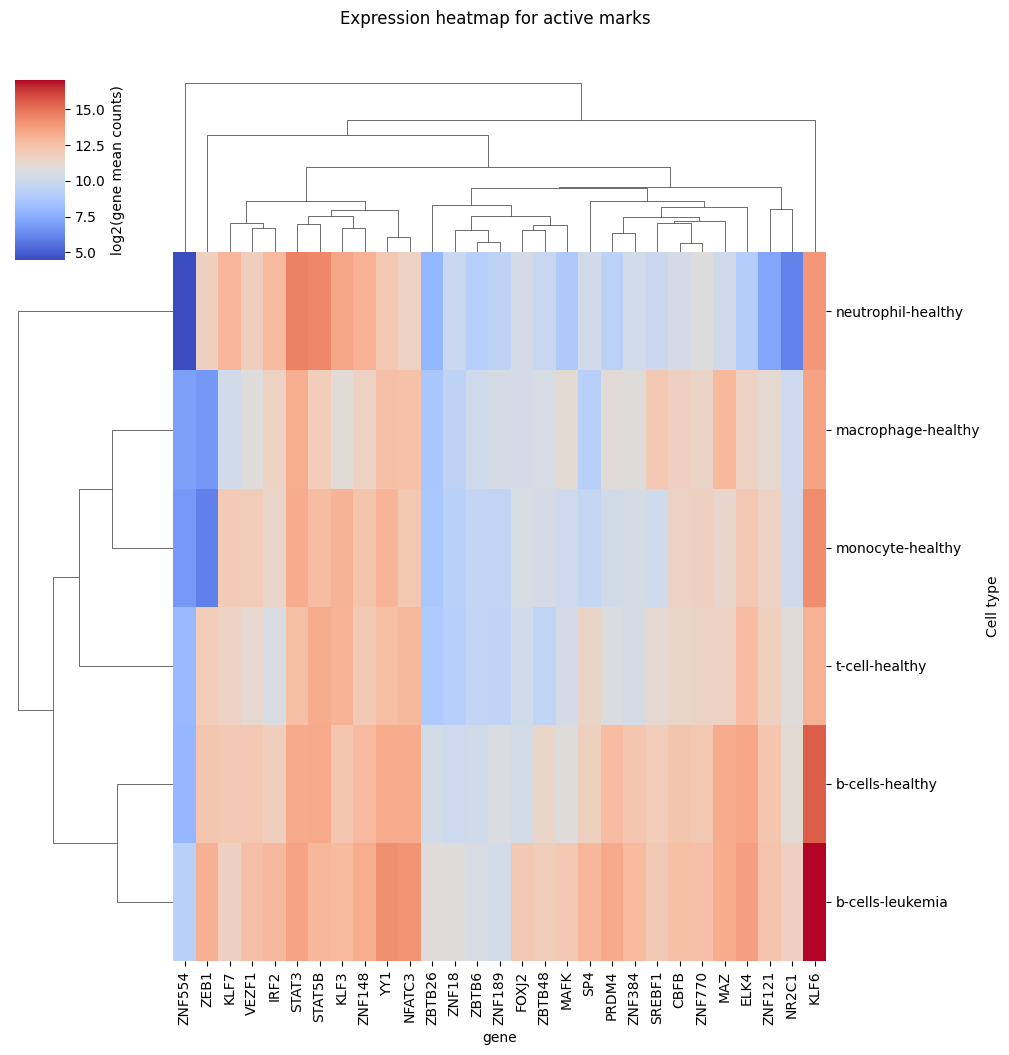

In [22]:
df_selected_genes = mean_expression_df[mean_expression_df["gene"].isin(celltype_specific_tf_set_active)]
df_transposed = df_selected_genes.set_index("gene").T

row_linkage = linkage(df_transposed, method="average", optimal_ordering=True)
col_linkage = linkage(df_transposed.T, method="average", optimal_ordering=True)
cg = sns.clustermap(df_transposed, row_linkage=row_linkage, col_linkage=col_linkage,annot=False, cmap="coolwarm", cbar=True)
cg.fig.suptitle("Expression heatmap for active marks",y=1.05)
ax = cg.ax_heatmap
ax.set_ylabel("Cell type")


colorbar = cg.ax_heatmap.collections[0].colorbar
colorbar.set_label("log2(gene mean counts)")

figure_file_name = "heatmap_expression_active"
plt.savefig(os.path.join(path_to_figure_folder, figure_file_name), bbox_inches='tight')

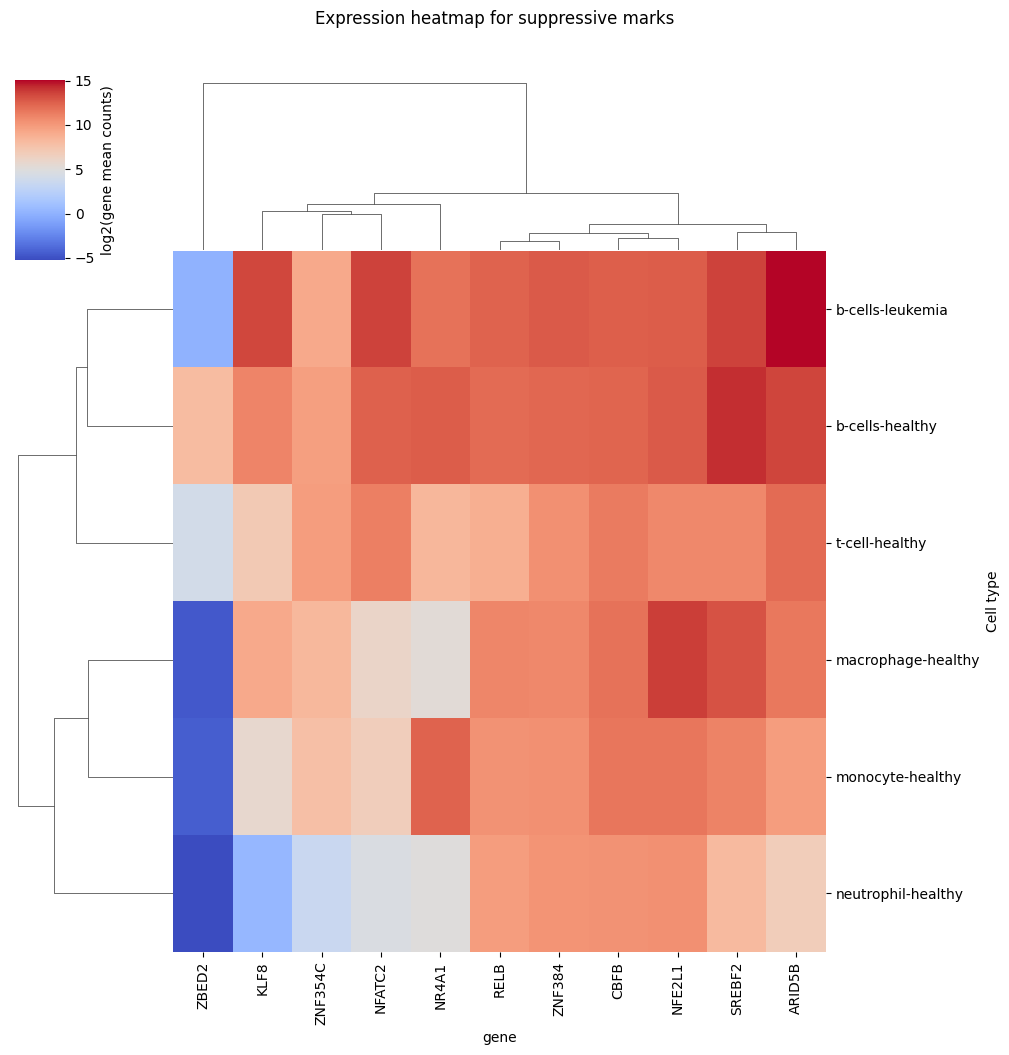

In [23]:
df_selected_genes = mean_expression_df[mean_expression_df["gene"].isin(celltype_specific_tf_set_suppressive)]
df_transposed = df_selected_genes.set_index("gene").T

row_linkage = linkage(df_transposed, method="average", optimal_ordering=True)
col_linkage = linkage(df_transposed.T, method="average", optimal_ordering=True)
cg = sns.clustermap(df_transposed, row_linkage=row_linkage, col_linkage=col_linkage,annot=False, cmap="coolwarm", cbar=True)
cg.fig.suptitle("Expression heatmap for suppressive marks",y=1.05)
ax = cg.ax_heatmap
ax.set_ylabel("Cell type")

colorbar = cg.ax_heatmap.collections[0].colorbar
colorbar.set_label("log2(gene mean counts)")
figure_file_name = "heatmap_expression_suppressive"
plt.savefig(os.path.join(path_to_figure_folder, figure_file_name), bbox_inches='tight')

In [28]:
celltype_specific_tf_with_asigned_celltype_list

['ZBTB6_b-cells-healthy',
 'KLF3_b-cells-healthy',
 'YY1_b-cells-healthy',
 'VEZF1_b-cells-healthy',
 'NR2C1_b-cells-healthy',
 'NR4A1_b-cells-healthy',
 'ZNF354C_b-cells-healthy',
 'KLF8_b-cells-healthy',
 'NFATC2_b-cells-healthy',
 'SREBF2_b-cells-healthy',
 'ZBED2_b-cells-healthy',
 'PRDM4_macrophage-healthy',
 'VEZF1_macrophage-healthy',
 'RELB_macrophage-healthy',
 'CBFB_macrophage-healthy',
 'ZNF384_t-cell-healthy',
 'SP4_t-cell-healthy',
 'NFATC3_t-cell-healthy',
 'STAT5B_t-cell-healthy',
 'ZNF554_t-cell-healthy',
 'STAT3_t-cell-healthy',
 'KLF7_t-cell-healthy',
 'ARID5B_t-cell-healthy',
 'NFE2L1_t-cell-healthy',
 'NFATC3_monocyte-healthy',
 'IRF2_monocyte-healthy',
 'ZNF770_monocyte-healthy',
 'KLF6_monocyte-healthy',
 'ZNF121_monocyte-healthy',
 'SREBF1_monocyte-healthy',
 'ZBTB48_neutrophil-healthy',
 'ZEB1_neutrophil-healthy',
 'ZNF148_neutrophil-healthy',
 'ZNF18_neutrophil-healthy',
 'ZBTB26_neutrophil-healthy',
 'MAFK_neutrophil-healthy',
 'MAZ_neutrophil-healthy',
 'FOXJ

macrophage-healthy-monocyte-healthy <br />
- HES6 -> nothing<br /> 
- DBP -> nothing<br /> 
- ETV5::HOXA2 <br />
-> as dimer and for HOXA2, in relation with monocytes/macrophages, found nothing <br />
For ETV5 - related pathways are IL12-mediated signaling (https://www.genecards.org/cgi-bin/carddisp.pl?gene=ETV5) <br />
-> IL12 is a interleukin thats produced by  dendritic cells, macrophages, neutrophils,T cell and B cells in response to antigenic stimulation
- ZBTB18 <br />
-> maybe: https://doi.org/10.1038/s41392-023-01727-7 (macro)
- ZNF454 -> nothing<br />
- ZNF701 -> nothing<br /> 
- SOX12 -> nothin<br />

b-cells-healthy-t-cell-healthy  <br />
- GFI1 hit<br />
https://www.genecards.org/cgi-bin/carddisp.pl?gene=GFI1 <br />
B-cell:<br />
https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0000306 <br />
https://ashpublications.org/blood/article/116/7/1060/27690/Repression-of-Id2-expression-by-Gfi-1-is-required 
-> usable example for target gene affinity <br />
T-cell:<br />
https://www.nature.com/articles/1205216?error=cookies_not_supported&code=3290fe0f-2fac-43e4-9fe9-ed6dfa7988b1 <br />
https://rupress.org/jem/article/197/7/831/39700/The-Transcriptional-Repressor-Gfi1-Affects <br />
https://www.pnas.org/doi/abs/10.1073/pnas.93.25.14569 <br />
https://academic.oup.com/nar/article/32/8/2508/2904550?login=false<br />

macrophage-healthy-t-cell-healthy <br />
- DMRTC2 -> nothing <br />

b-cells-healthy-monocyte-healthy <br />
- ELF2 -> maybe <br />
Among its related pathways are Gene expression (Transcription) and Immune response IL-23 signaling pathway.
https://www.genecards.org/cgi-bin/carddisp.pl?gene=ELF2 <br />
- MLXIPL ->nothing <br />

t-cell-healthy-neutrophil-healthy <br />
- STAT1 -> maybe <br />
https://www.genecards.org/cgi-bin/carddisp.pl?gene=STAT1 (didnot found paper  with relation to t-cellor neutrophil)
- JUNB -> not directly but via AP-1<br />
Regulation of T cell differentiation by the AP-1 transcription factor JunB https://www.tandfonline.com/doi/full/10.1080/25785826.2021.1872838?cookieSet=1 

b-cells-healthy-macrophage-healthy <br />
- ZFP14 -> nothing <br />
- TFAP4::ETV1 -> maybe maybe<br />
Nothing on both, for ETV1:<br />
ETV1 inhibition depressed M2 polarization of tumor-associated macrophage and cell process in gastrointestinal stromal tumor via down-regulating PDE3A https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10017324/ <br />

b-cells-healthy-b-cells-leukemia <br />
- HOXB7 <br /> ->  nothing
- HESX1 <br /> -> nothing
- MYCN <br />
- TBX6 <br />
- TEAD2 <br />
- HOXA5 <br /> -> potential therapeutic target
- SPIB <br />
ETV6-RUNX1 interacts with a region in SPIB intron 1 to regulate gene expression in pre-B-cell acute lymphoblastic leukemia https://www.sciencedirect.com/science/article/pii/S0301472X19301341 <br />
Expression and Clinical Significance of Spi-B in B-cell Acute Lymphoblastic Leukemia https://journals.sagepub.com/doi/full/10.1369/00221554221130383 <br />
- MYB <br /> -> potential tehrapeutic target

monocyte-healthy-t-cell-healthy <br />
- ZKSCAN1 -> nothing<br />
- STAT1::STAT2 <br />
"STAT1 and STAT2 are key components of the transcription factor complex in the IFN signaling pathways"
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3772101/<br />
(monocyte) 
https://journals.aai.org/jimmunol/article-abstract/159/2/794/110756/Interferons-up-regulate-STAT1-STAT2-and-IRF-family <br />

b-cells-healthy-neutrophil-healthy <br />
- PLAG1 -> nothing<br />
- SPI1 <br />
This gene encodes an ETS-domain transcription factor that activates gene expression during myeloid and B-lymphoid cell development. https://www.genecards.org/cgi-bin/carddisp.pl?gene=SPI1
- EGR1 <br />
- CEBPG <br />

# compare TFs with TFs from other paper
TF are from figure 4,  section C from
https://www.biorxiv.org/content/10.1101/2022.12.12.520141v1.full

## compare with created cell type  specific TFs

In [42]:
paper_tfs = {
    "GLYR1", "NR2C2", "RFX2", "HMGN3", "ZNF644", "ZNF197", "BTF3", "ZBTB11",
    "MYC", "TCF7", "STAT5B", "ETS1", "ZNF3", "MAF", "MAZ", "TMEFF2",
    "THAP11", "NFKB1", "ZNF584", "BACH2", "ZNF716", "TBX21", "GATA3",
    "IRF3", "BATF", "ZNF165", "STAT2", "NR1I2", "PRDM1", "GATA6", "SP4",
    "CBX4", "TCF4", "ZKSCAN1", "RFX5", "ZNF318", "ZNF92", "IRF4", "ADN",
    "PAX5", "MEF2A", "POU2F2", "SPIB", "LYF1", "TERF1", "E2F1", "NCOA3",
    "ZEB1"
}
len(paper_tfs)

48

In [41]:
for comparison, row in df_cell_type_tfs.iterrows():
    for marker in df_cell_type_tfs.columns:
        if len(paper_tfs.intersection(row[marker]))>0:
            print(comparison + " "+ marker + str(paper_tfs.intersection(row[marker])))

t-cell-healthy active_markers{'SP4', 'STAT5B'}
neutrophil-healthy active_markers{'MAZ', 'ZEB1'}


SP4 in paper: CD8 naive, CD8Tem_2, gdT <br />
STAT5B in paper: CD$ Naive, CD4 TCM,CD4 TEM <br />
MAZ in paper: CD4 TCM,  (CD4 TEM), CD8 TEM_1, CD8 TEM_2, HSPC<br />
ZEB1 in paper: (CD4 TCEM), CD8 Naive, (pDC,Treg)<br />


## compare with each comparison set (not sure if worth mentioning)

In [43]:

for comparison, row in tf_overlap_df_tpm.iterrows():
    for marker in tf_overlap_df_tpm.columns:
        if len(paper_tfs.intersection(row[marker]))>0:
            print(comparison + " "+ marker + str(paper_tfs.intersection(row[marker])))

NameError: name 'paper_tfs' is not defined

# use ORA on the TFs

macrophage-healthy-monocyte-healthy <br />
- HES6 -> nothing<br /> 
- DBP -> nothing<br /> 
- ETV5::HOXA2 <br />
-> as dimer and for HOXA2, in relation with monocytes/macrophages, found nothing <br />
For ETV5 - related pathways are IL12-mediated signaling (https://www.genecards.org/cgi-bin/carddisp.pl?gene=ETV5) <br />
-> IL12 is a interleukin thats produced by  dendritic cells, macrophages, neutrophils,T cell and B cells in response to antigenic stimulation
- ZBTB18 <br />
-> maybe: https://doi.org/10.1038/s41392-023-01727-7 (macro)
- ZNF454 -> nothing<br />
- ZNF701 -> nothing<br /> 
- SOX12 -> nothin<br />

b-cells-healthy-t-cell-healthy  <br />
- GFI1 hit<br />
https://www.genecards.org/cgi-bin/carddisp.pl?gene=GFI1 <br />
B-cell:<br />
https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0000306 <br />
https://ashpublications.org/blood/article/116/7/1060/27690/Repression-of-Id2-expression-by-Gfi-1-is-required 
-> usable example for target gene affinity <br />
T-cell:<br />
https://www.nature.com/articles/1205216?error=cookies_not_supported&code=3290fe0f-2fac-43e4-9fe9-ed6dfa7988b1 <br />
https://rupress.org/jem/article/197/7/831/39700/The-Transcriptional-Repressor-Gfi1-Affects <br />
https://www.pnas.org/doi/abs/10.1073/pnas.93.25.14569 <br />
https://academic.oup.com/nar/article/32/8/2508/2904550?login=false<br />

macrophage-healthy-t-cell-healthy <br />
- DMRTC2 -> nothing <br />

b-cells-healthy-monocyte-healthy <br />
- ELF2 -> maybe <br />
Among its related pathways are Gene expression (Transcription) and Immune response IL-23 signaling pathway.
https://www.genecards.org/cgi-bin/carddisp.pl?gene=ELF2 <br />
- MLXIPL ->nothing <br />

t-cell-healthy-neutrophil-healthy <br />
- STAT1 -> maybe <br />
https://www.genecards.org/cgi-bin/carddisp.pl?gene=STAT1 (didnot found paper  with relation to t-cellor neutrophil)
- JUNB -> not directly but via AP-1<br />
Regulation of T cell differentiation by the AP-1 transcription factor JunB https://www.tandfonline.com/doi/full/10.1080/25785826.2021.1872838?cookieSet=1 

b-cells-healthy-macrophage-healthy <br />
- ZFP14 -> nothing <br />
- TFAP4::ETV1 -> maybe maybe<br />
Nothing on both, for ETV1:<br />
ETV1 inhibition depressed M2 polarization of tumor-associated macrophage and cell process in gastrointestinal stromal tumor via down-regulating PDE3A https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10017324/ <br />

b-cells-healthy-b-cells-leukemia <br />
- HOXB7 <br /> ->  nothing
- HESX1 <br /> -> nothing
- MYCN <br />
- TBX6 <br />
- TEAD2 <br />
- HOXA5 <br /> -> potential therapeutic target
- SPIB <br />
ETV6-RUNX1 interacts with a region in SPIB intron 1 to regulate gene expression in pre-B-cell acute lymphoblastic leukemia https://www.sciencedirect.com/science/article/pii/S0301472X19301341 <br />
Expression and Clinical Significance of Spi-B in B-cell Acute Lymphoblastic Leukemia https://journals.sagepub.com/doi/full/10.1369/00221554221130383 <br />
- MYB <br /> -> potential tehrapeutic target

monocyte-healthy-t-cell-healthy <br />
- ZKSCAN1 -> nothing<br />
- STAT1::STAT2 <br />
"STAT1 and STAT2 are key components of the transcription factor complex in the IFN signaling pathways"
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3772101/<br />
(monocyte) 
https://journals.aai.org/jimmunol/article-abstract/159/2/794/110756/Interferons-up-regulate-STAT1-STAT2-and-IRF-family <br />

b-cells-healthy-neutrophil-healthy <br />
- PLAG1 -> nothing<br />
- SPI1 <br />
This gene encodes an ETS-domain transcription factor that activates gene expression during myeloid and B-lymphoid cell development. https://www.genecards.org/cgi-bin/carddisp.pl?gene=SPI1
- EGR1 <br />
- CEBPG <br />

creating list of TFs for background and gene sets for the ORA

In [24]:
all_tfs = pd.read_csv(path_to_all_tfs_file, sep="\t").columns.values
all_tfs_adjusted = myfunc.adjust_tfprio_used_TF(all_tfs)
#all_tfs_adjusted = adjust_tfprio_used_TF(all_tfs)
print(len(all_tfs))
print(len(all_tfs_adjusted))

819
714


In [25]:
msig = Msigdb()

# normal gene sets
MSigDB_regulatory_target = msig.get_gmt(category='c3.all', dbver="2023.2.Hs")
MSigDB_GO = msig.get_gmt(category='c5.go', dbver="2023.2.Hs")
MSigDB_immunologic_signature = msig.get_gmt(category='c7.immunesigdb', dbver="2023.2.Hs")
MSigDB_cell_type = msig.get_gmt(category='c8.all', dbver="2023.2.Hs")
MSigDB_hallmarks = msig.get_gmt(category='h.all', dbver="2023.2.Hs")
gseapy_cell_marker_augmented = gp.get_library(name='CellMarker_Augmented_2021', organism='Human')
kegg = gp.get_library(name='KEGG_2021_Human', organism='Human')

normal_gene_sets = [MSigDB_regulatory_target, MSigDB_immunologic_signature, MSigDB_cell_type, 
                    MSigDB_GO, MSigDB_hallmarks, gseapy_cell_marker_augmented, kegg]

In [26]:
normal_gene_sets_renaming = {
                            "gs_ind_0": "MSigDB_Regulatory_Targets_2023",
                            "gs_ind_1": "MSigDB_Immunologic_Signatures_2023",
                            "gs_ind_2": "MSigDB_Cell_Type_Signatures_2023",
                            "gs_ind_3": "MSigDB_Gene_Ontology_2023",
                            "gs_ind_4": "MSigDB_Hallmark_2023",
                            "gs_ind_5": "CellMarker_Augmented_2021",
                            "gs_ind_6": "KEGG_2021_Human"}

For b-cells-healthy_suppressive_marks
For neutrophil-healthy_active_marks


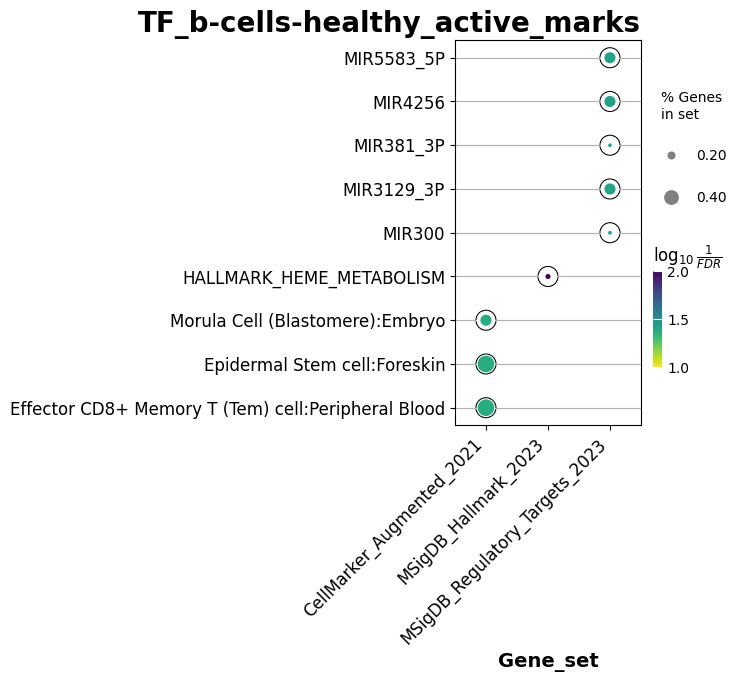

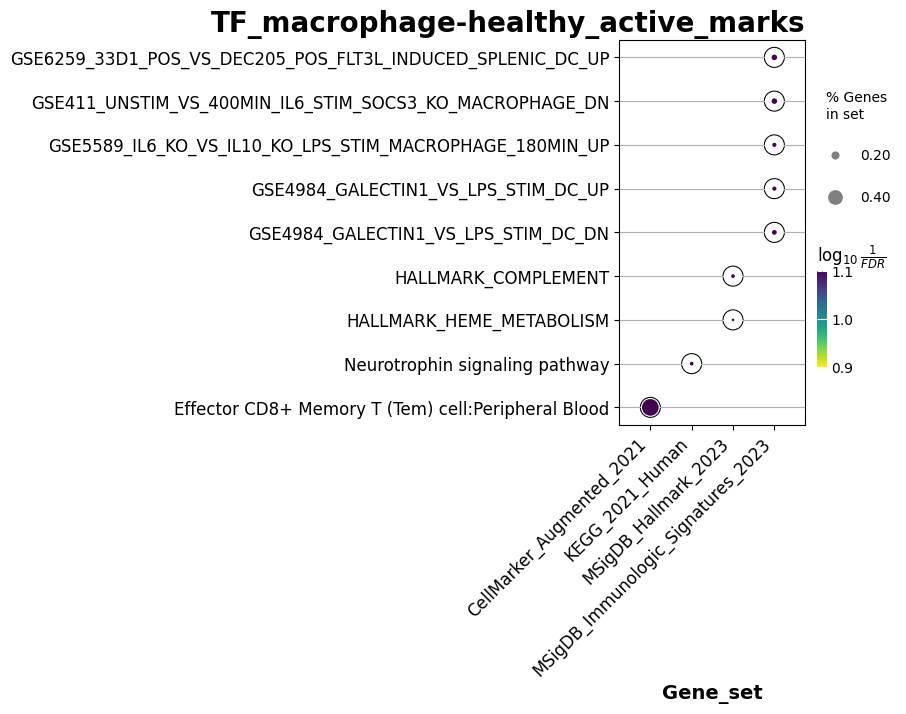

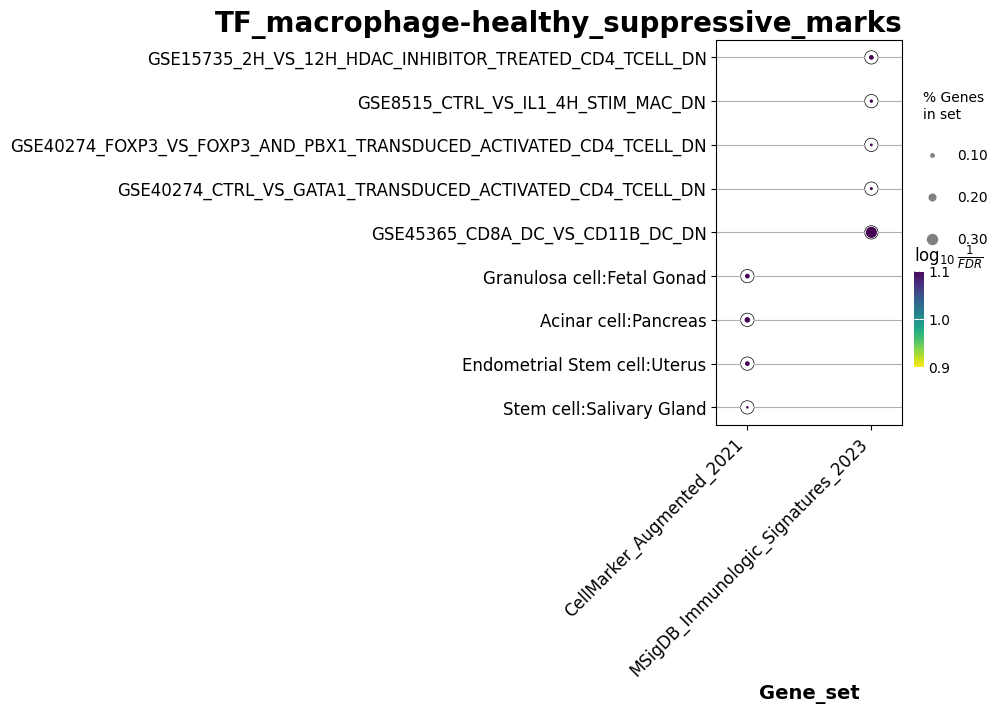

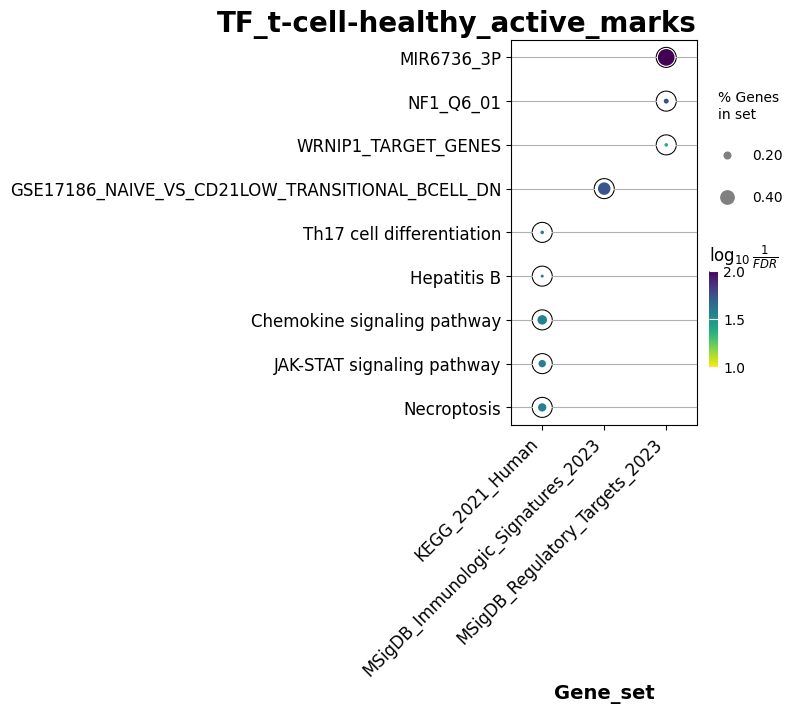

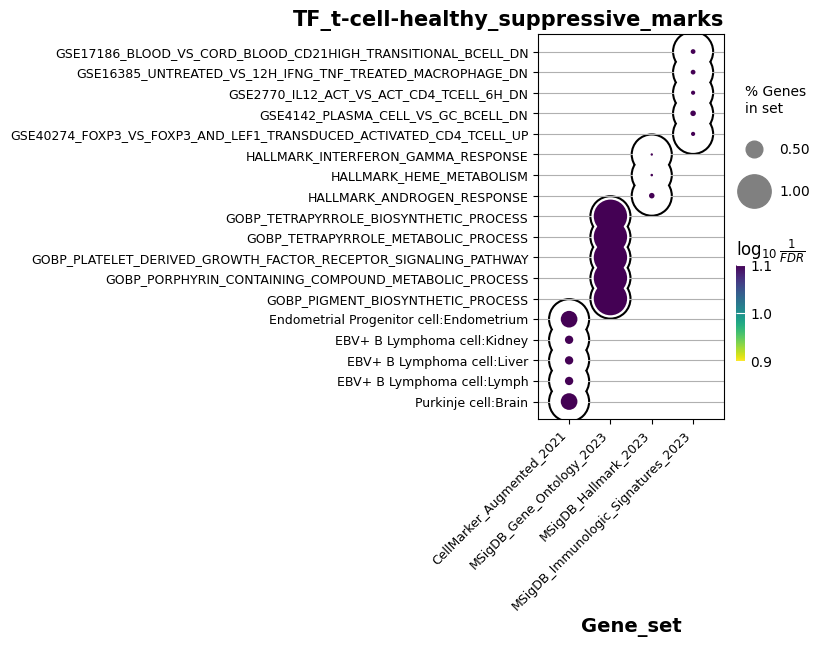

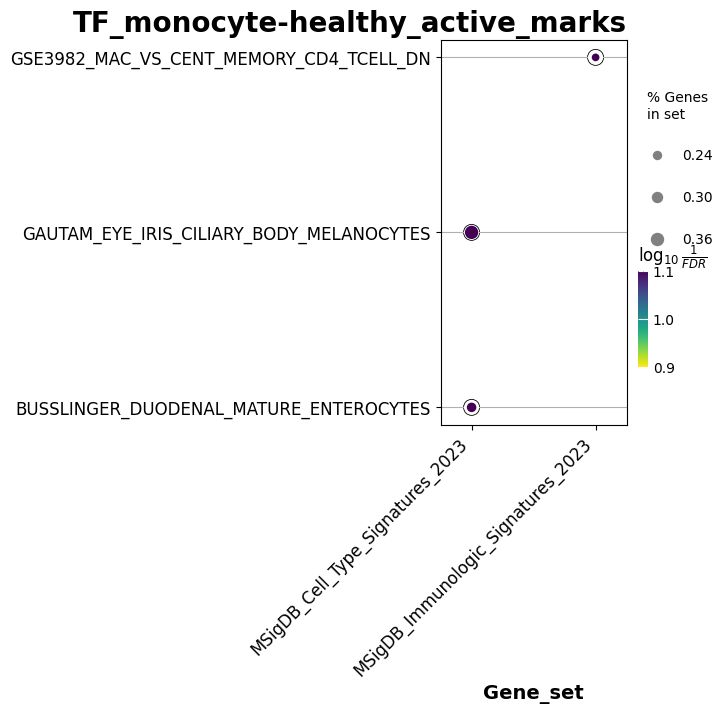

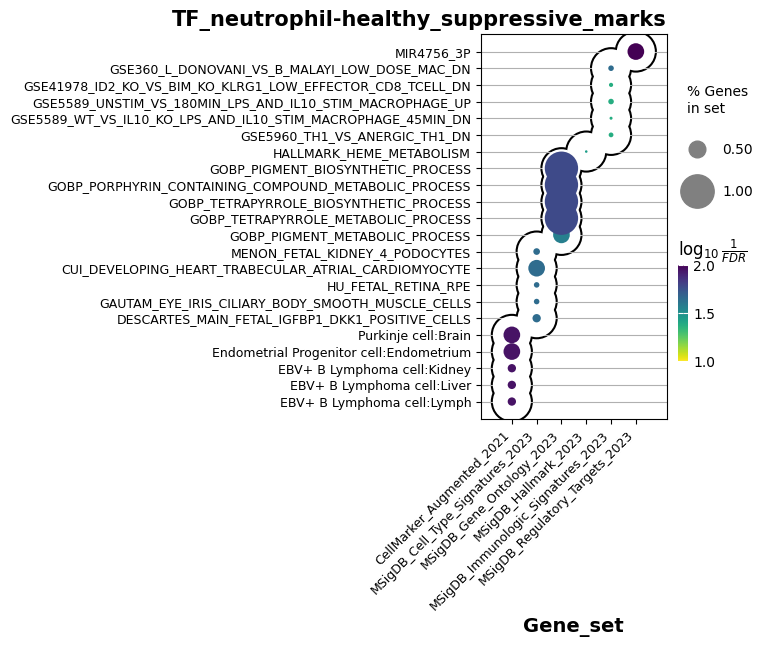

In [28]:
tf_results_dictionary = {}
for index, row in df_cell_type_tfs.iterrows():
    for tf_type in df_cell_type_tfs.columns:
        if len(row[tf_type]) > 0:
            genes = list(myfunc.adjust_tfprio_used_TF(row[tf_type]))
            enr_bg = gp.enrichr(gene_list=genes,
                        gene_sets=normal_gene_sets,
                        #organism='human', # organism argment is ignored because user input a background
                        background=all_tfs_adjusted,
                        outdir=None, # don't write to disk
                        )
            enr_bg.results["Gene_set"] = enr_bg.results["Gene_set"].replace(normal_gene_sets_renaming)
            try:
                ax = gp.dotplot(enr_bg.results,
                            column="Adjusted P-value",
                            x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
                            size=4,
                            top_term=5,
                            figsize=(3,5),
                            xticklabels_rot=45, # rotate xtick labels
                            show_ring=True, # set to False to revmove outer ring
                            marker='o',
                            )
                x_axis_size, y_axis_size, title_size = myfunc.enrichr_adjust_axis_title_font_sizes(enr_bg.results)
                ax.tick_params(axis='x', labelsize=x_axis_size)
                ax.tick_params(axis='y', labelsize=y_axis_size)
                ax.set_title("TF_"+index+"_"+tf_type, loc="right", fontsize=title_size,fontweight='bold')
                figure_file_name = "ORA_celltype_specific_TF_"+index+"_"+tf_type
                plt.savefig(os.path.join(path_to_figure_folder, figure_file_name), bbox_inches='tight')
                tf_results_dictionary[index+"_"+tf_type] = enr_bg.results
            except ValueError as ve:
                print("For "+str(index)+"_"+tf_type)
                print(ve)

# ORA on TGs

## get target genes

reading in the gtf dictionary, based on the gtf file, that is used for the conversion of ensg symbols to hgnc symbols

In [8]:
gtf_dict = myfunc.read_gtf_and_create_ensg_hgnc_dict()

In [19]:
df_cell_type_tfs

active_marks  \
b-cells-healthy                      {VEZF1, KLF3, YY1, NR2C1, ZBTB6}   
macrophage-healthy                                     {VEZF1, PRDM4}   
t-cell-healthy      {ZNF554, NFATC3, ZNF384, STAT5B, KLF7, SP4, ST...   
monocyte-healthy         {NFATC3, ZNF121, IRF2, KLF6, SREBF1, ZNF770}   
neutrophil-healthy  {MAFK, ZEB1, KLF6, MAZ, ZBTB48, ZBTB26, ZNF18,...   

                                                suppressive_marks  
b-cells-healthy     {KLF8, SREBF2, NR4A1, ZNF354C, NFATC2, ZBED2}  
macrophage-healthy                                   {RELB, CBFB}  
t-cell-healthy                                   {NFE2L1, ARID5B}  
monocyte-healthy                                               {}  
neutrophil-healthy                               {NFE2L1, ZNF384}

creating dataframes with either top K TGs for every TF or all TGs for every TF (above the affinity threshold)

In [9]:
# takes about ~35-40min
df_celltype_top_k_tg = myfunc.read_out_filtered_target_genes_df(df_cell_type_tfs, path_to_main_comparison_dir, per_cell_type=True)
df_celltype_all_tgs = myfunc.read_out_filtered_target_genes_df(df_cell_type_tfs, path_to_main_comparison_dir, modus = "all_genes", per_cell_type=True)

converting the ENSG gene sets to HGNC gene sets

In [10]:
df_celltype_top_k_tg_hgnc = df_celltype_top_k_tg.applymap(lambda x: myfunc.convert_ensg_to_hgnc(x, gtf_dict))
df_celltype_all_tgs_hgnc = df_celltype_all_tgs.applymap(lambda x: myfunc.convert_ensg_to_hgnc(x, gtf_dict))

Displaying obtained TG set sizes

In [42]:
df_celltype_top_k_tg_hgnc.applymap( lambda x: len(x))

active_marks  suppressive_marks
b-cells-healthy                0                  1
macrophage-healthy             4                  0
t-cell-healthy               117                  0
monocyte-healthy              92                  0
neutrophil-healthy            22                 59

In [43]:
df_celltype_all_tgs_hgnc.applymap( lambda x: len(x))

active_marks  suppressive_marks
b-cells-healthy                0                  1
macrophage-healthy             4                  0
t-cell-healthy             25036                  0
monocyte-healthy             801                  0
neutrophil-healthy            22               5875

##### testing why theres differences - add print statements in function to seewheresomeTFs are left out (orareextra for top k)

In [16]:
df_celltype_top_k_tg_test = myfunc.read_out_filtered_target_genes_df(df_cell_type_tfs_test, path_to_main_comparison_dir)
#df_celltype_all_tgs_test = read_out_filtered_target_genes_df(df_cell_type_tfs_test, path_to_main_comparison_dir, modus = "all_genes")

In [174]:
df_celltype_all_tgs_test.applymap(lambda x: len(set(x)))

active_marks  suppressive_marks
b-cells-healthy               33                  1
macrophage-healthy            27                  0
neutrophil-healthy           165              28314

In [17]:
# with testing
df_celltype_top_k_tg_test.applymap(lambda x: len(set(x)))

active_marks  suppressive_marks
b-cells-healthy               27                  1
macrophage-healthy            27                  0
neutrophil-healthy           157                290

In [17]:
# with improved code
df_celltype_top_k_tg.applymap(lambda x: len(set(x)))

active_marks  suppressive_marks
b-cells-healthy                0                  1
macrophage-healthy             4                  0
t-cell-healthy               120                  0
monocyte-healthy              94                  0
neutrophil-healthy            22                 60

In [12]:
# with improved code
df_celltype_top_k_tg.applymap(lambda x: len(set(x)))

active_marks  suppressive_marks
b-cells-healthy                0                  1
macrophage-healthy             4                  0
t-cell-healthy               120                  0
monocyte-healthy              94                  0
neutrophil-healthy            22                 60

In [13]:
df_celltype_all_tgs.applymap(lambda x: len(set(x)))

active_marks  suppressive_marks
b-cells-healthy                0                  1
macrophage-healthy             4                  0
t-cell-healthy             25784                  0
monocyte-healthy             830                  0
neutrophil-healthy            22               5983

In [18]:
df_celltype_all_tgs.applymap(lambda x: len(set(x)))

active_marks  suppressive_marks
b-cells-healthy                0                  1
macrophage-healthy             4                  0
t-cell-healthy             25784                  0
monocyte-healthy             830                  0
neutrophil-healthy            22               5983

In [175]:
df_celltype_top_k_tg_test.applymap(lambda x: len(set(x)))

active_marks  suppressive_marks
b-cells-healthy               42                  1
macrophage-healthy            43                  0
neutrophil-healthy           224                520

In [11]:
df_celltype_top_k_tg_test_hgnc = df_celltype_top_k_tg.applymap(lambda x: myfunc.convert_ensg_to_hgnc(x, gtf_dict))
df_celltype_all_tgs_test_hgnc = df_celltype_all_tgs_test.applymap(lambda x: myfunc.convert_ensg_to_hgnc(x, gtf_dict))

NameError: name 'df_celltype_all_tgs_test' is not defined

In [170]:
df_celltype_top_k_tg_test_hgnc.applymap(lambda x: len(set(x)))

active_marks  suppressive_marks
b-cells-healthy               41                  1
macrophage-healthy            41                  0
t-cell-healthy               654                  0
monocyte-healthy             480                  0
neutrophil-healthy           221                509

In [169]:
df_celltype_all_tgs_test_hgnc.applymap(lambda x: len(x))

active_marks  suppressive_marks
b-cells-healthy               32                  1
macrophage-healthy            26                  0
t-cell-healthy             31663                  0
monocyte-healthy            2867                  0
neutrophil-healthy           162              27627

In [34]:
df_top_k_tg_hgnc.applymap(lambda x: len(set(x)))

active_markers  suppressive_markers
b-cells-healthy                 33                    1
macrophage-healthy              27                    0
t-cell-healthy               32565                    0
monocyte-healthy              2977                    0
neutrophil-healthy             165                28314

In [ ]:
df_all_tgs_hgnc.applymap(lambda x: len(set(x)))

In [19]:
df_celltype_all_tgs_hgnc.applymap(lambda x: len(x))

active_marks  suppressive_marks
b-cells-healthy                0                  1
macrophage-healthy             4                  0
t-cell-healthy             25036                  0
monocyte-healthy             801                  0
neutrophil-healthy            22               5875

In [30]:
df_cell_type_tfs_k_genes

active_markers  \
b-cells-healthy                                                    []   
macrophage-healthy  [ENSG00000175309, ENSG00000037965, ENSG0000027...   
t-cell-healthy      [ENSG00000200118, ENSG00000272536, ENSG0000017...   
monocyte-healthy    [ENSG00000268618, ENSG00000275997, ENSG0000018...   
neutrophil-healthy  [ENSG00000240626, ENSG00000173237, ENSG0000023...   

                                                  suppressive_markers  
b-cells-healthy     [ENSG00000265924, ENSG00000265924, ENSG0000026...  
macrophage-healthy                                                 []  
t-cell-healthy                                                     []  
monocyte-healthy                                                   []  
neutrophil-healthy  [ENSG00000182963, ENSG00000131097, ENSG0000022...

In [163]:
df_celltype_top_k_tg_hgnc.applymap(lambda x: len(x))

active_marks  suppressive_marks
b-cells-healthy                0                  1
macrophage-healthy            12                  0
t-cell-healthy               174                  0
monocyte-healthy             123                  0
neutrophil-healthy            25                172

In [164]:
df_celltype_all_tgs_hgnc.applymap(lambda x: len(x))

active_marks  suppressive_marks
b-cells-healthy                0                  1
macrophage-healthy             4                  0
t-cell-healthy             25036                  0
monocyte-healthy             801                  0
neutrophil-healthy            22               5875

In [53]:
df_cell_type_tfs_k_genes.applymap(lambda x: len(set(x)))

active_markers  suppressive_markers
b-cells-healthy                  0                    1
macrophage-healthy              13                    0
t-cell-healthy                 180                    0
monocyte-healthy               125                    0
neutrophil-healthy              25                  175

In [17]:
#dict_all_genes_top_tf = myfunc.read_out_filtered_target_genes_dict(tf_overlap_df_tpm_limited, path_to_main_comparison_dir, modus="all_genes")
df_cell_type_tfs_all_tgs = pd.DataFrame.from_dict(myfunc.read_out_filtered_target_genes_dict(df_cell_type_tfs, path_to_main_comparison_dir, modus = "all_genes"), orient="index")


In [8]:
df_cell_type_tfs_all_tgs_new = pd.DataFrame.from_dict(myfunc.read_out_filtered_target_genes_per_celltype_dict(df_cell_type_tfs, path_to_main_comparison_dir, modus = "all_genes"), orient="index")


In [10]:
df_cell_type_tfs_all_tgs_new.applymap(lambda x: len(x))

active_markers  suppressive_markers
b-cells-healthy                  0                    5
macrophage-healthy              52                    0
t-cell-healthy              251340                    0
monocyte-healthy              3532                    0
neutrophil-healthy             113                84546

In [9]:
df_cell_type_tfs_all_tgs_new.applymap(lambda x: len(set(x)))

active_markers  suppressive_markers
b-cells-healthy                  0                    1
macrophage-healthy              13                    0
t-cell-healthy               36896                    0
monocyte-healthy               879                    0
neutrophil-healthy              25                16198

In [13]:
df_cell_type_tfs_all_tgs.applymap(lambda x: len(set(x)))

active_markers  suppressive_markers
b-cells-healthy                 55                    1
macrophage-healthy              49                    0
t-cell-healthy               45892                    0
monocyte-healthy              3567                    0
neutrophil-healthy             274                45892

In [16]:
df_cell_type_tfs_k_genes
df_cell_type_tfs_k_genes.applymap(lambda x: len(x))

active_markers  suppressive_markers
b-cells-healthy                 42                    4
macrophage-healthy              81                    0
t-cell-healthy                1080                    0
monocyte-healthy               824                    0
neutrophil-healthy             330                  781

In [17]:
df_cell_type_tfs_k_genes.applymap(lambda x: len(set(x)))

active_markers  suppressive_markers
b-cells-healthy                 42                    1
macrophage-healthy              49                    0
t-cell-healthy                 674                    0
monocyte-healthy               494                    0
neutrophil-healthy             224                  551

## ORA on top K TG

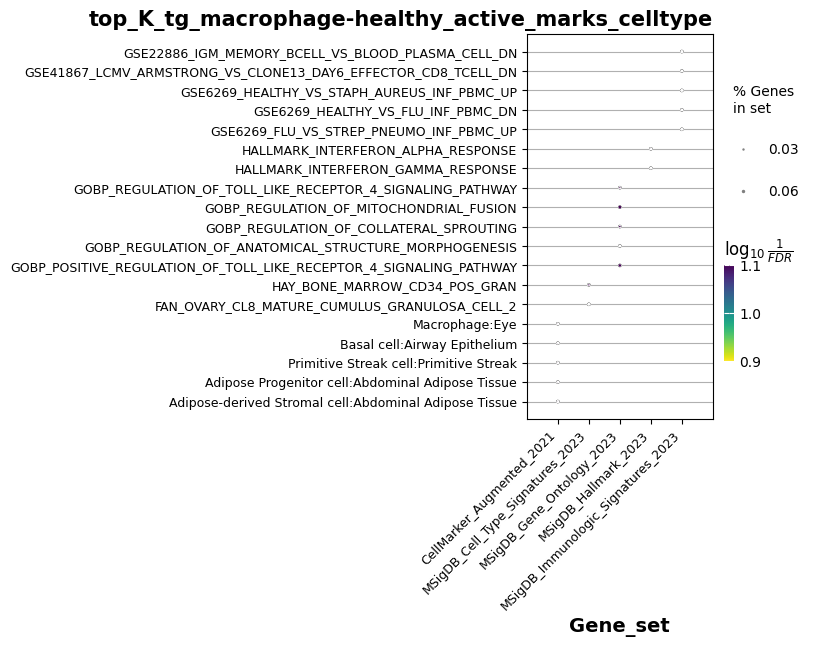

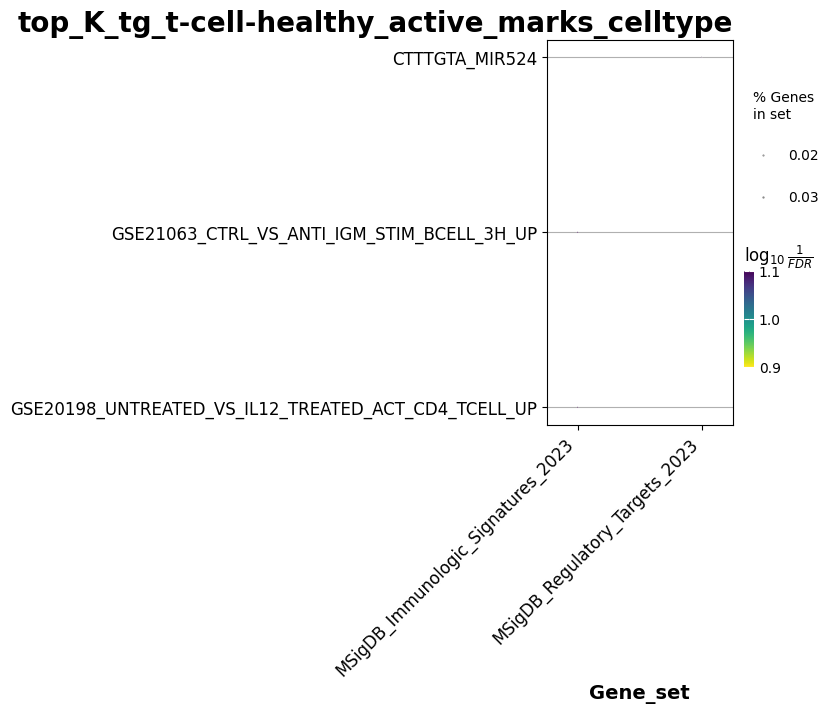

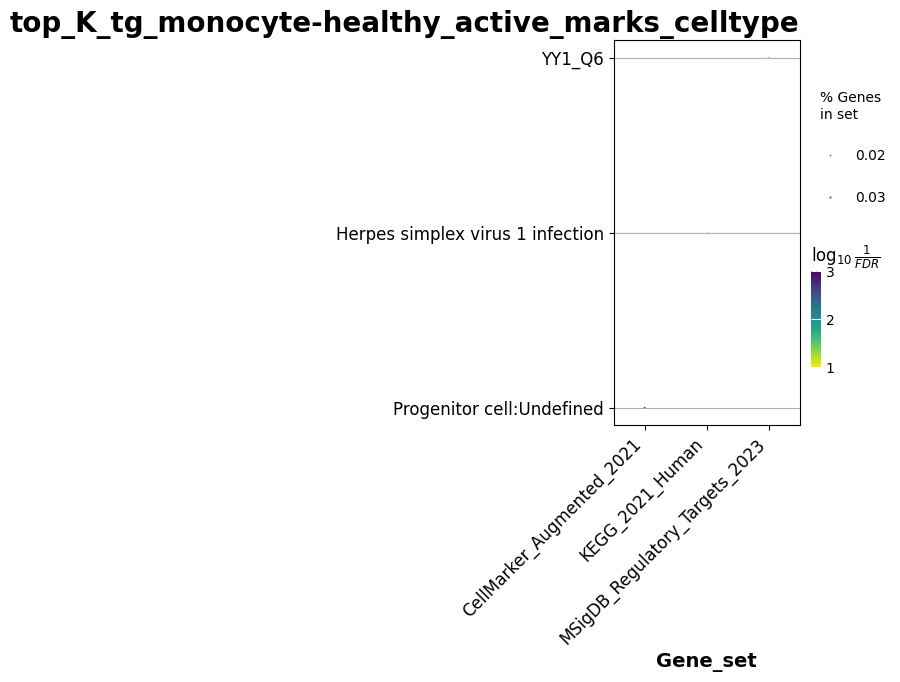

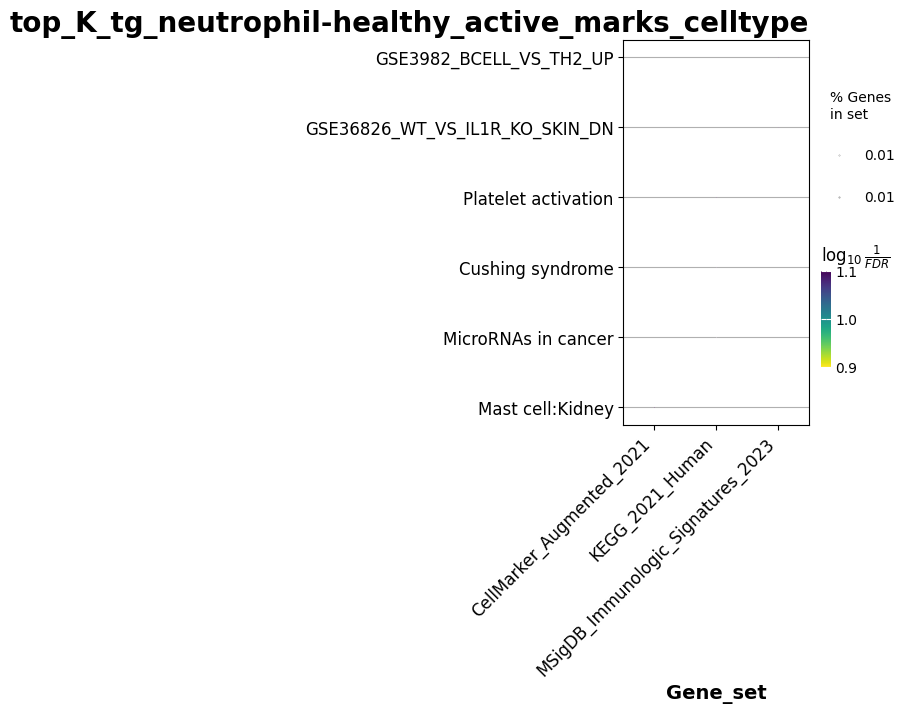

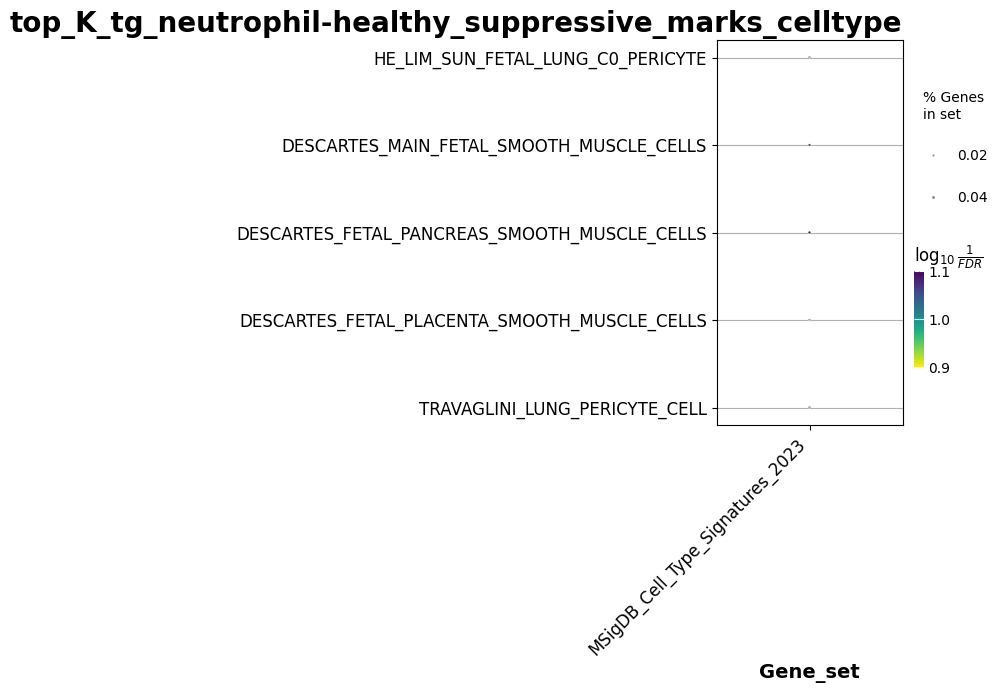

In [45]:
celltypes_top_k_tg_results_dictionary = {}
for index, row in df_celltype_top_k_tg_hgnc.iterrows():
    for tf_type in df_celltype_top_k_tg_hgnc.columns:
        genes = list(myfunc.adjust_tfprio_used_TF(row[tf_type]))
        if len(genes)>1:
            enr_bg = gp.enrichr(gene_list=genes,
                        gene_sets=normal_gene_sets,
                        organism='human', # organism argment is ignored because user input a background
                        outdir=None, # don't write to disk
                        )
            enr_bg.results["Gene_set"] = enr_bg.results["Gene_set"].replace(normal_gene_sets_renaming)
            try:
                ax = gp.dotplot(enr_bg.results,
                            column="Adjusted P-value",
                            x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
                            size=4,
                            top_term=5,
                            figsize=(3,5),
                            xticklabels_rot=45, # rotate xtick labels
                            show_ring=True, # set to False to revmove outer ring
                            marker='o',
                            )
                x_axis_size, y_axis_size, title_size = myfunc.enrichr_adjust_axis_title_font_sizes(enr_bg.results)
                ax.tick_params(axis='y', labelsize=y_axis_size)
                ax.tick_params(axis='x', labelsize=x_axis_size)
                ax.set_title("top_K_tg_"+index+"_"+tf_type+"_celltype", loc="right", fontsize=title_size,fontweight='bold')
                figure_file_name = "ORA_top_k_TG_"+index+"_"+tf_type+"_celltypes"
                plt.savefig(os.path.join(path_to_figure_folder, figure_file_name), bbox_inches='tight')
                celltypes_top_k_tg_results_dictionary[index+"_"+tf_type] = enr_bg.results
            except ValueError as ve:
                print("For "+str(index)+"_"+tf_type)
                print(ve)

## ORA on all TG

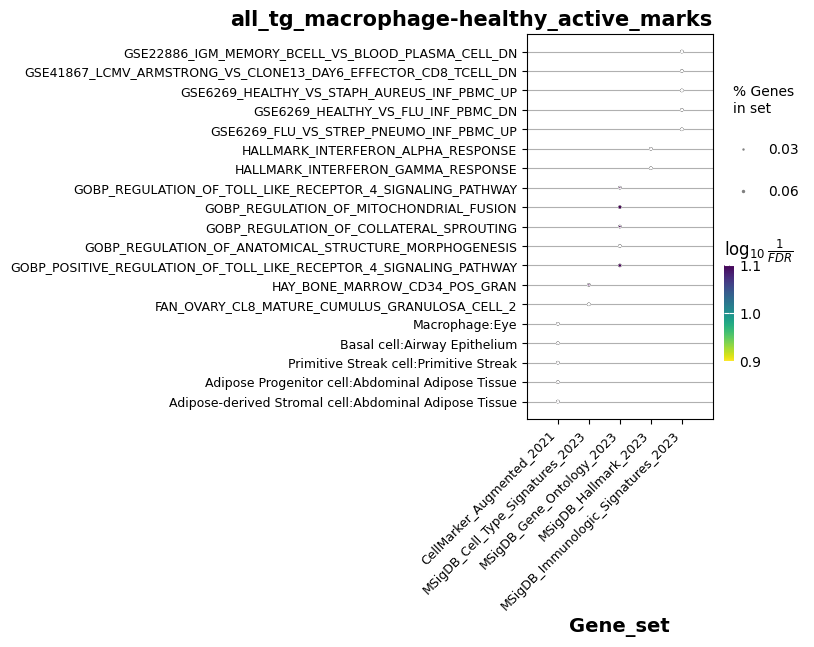

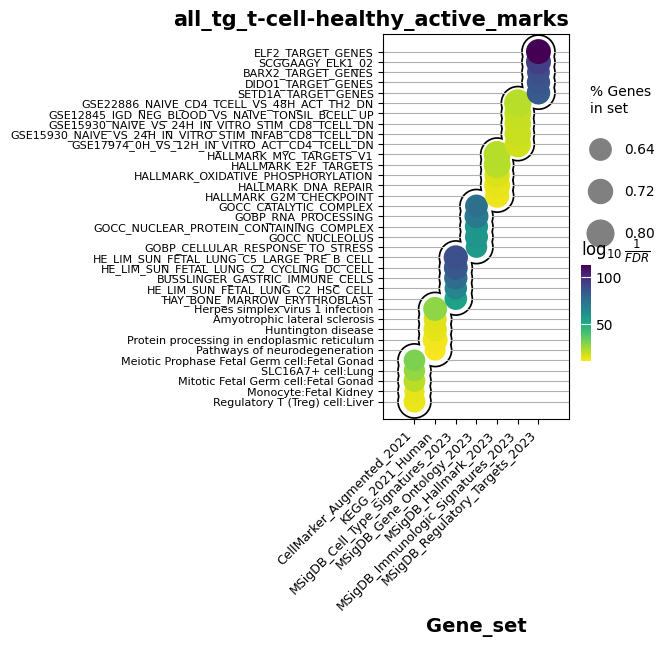

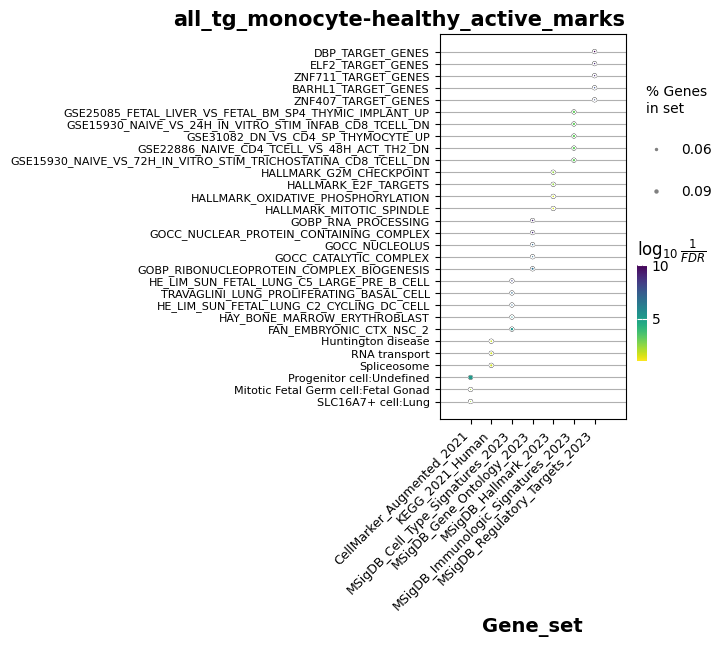

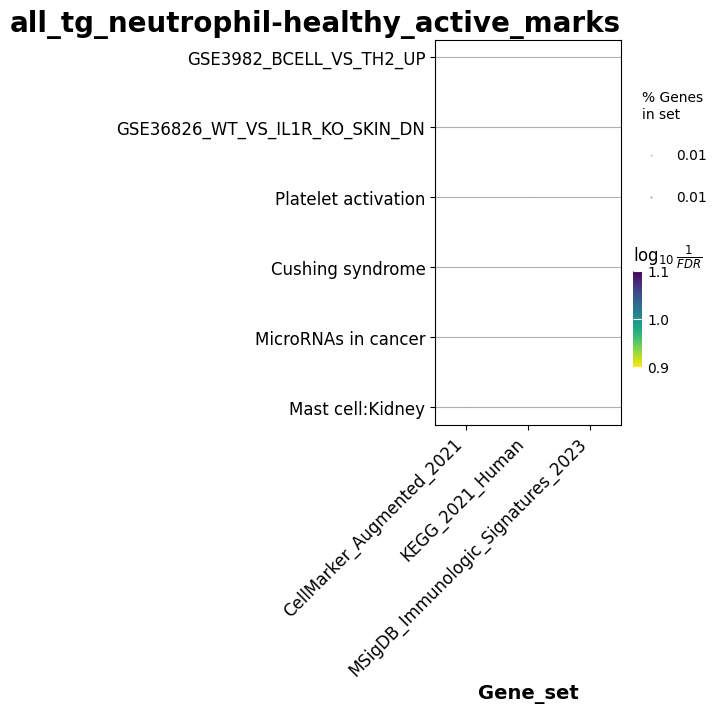

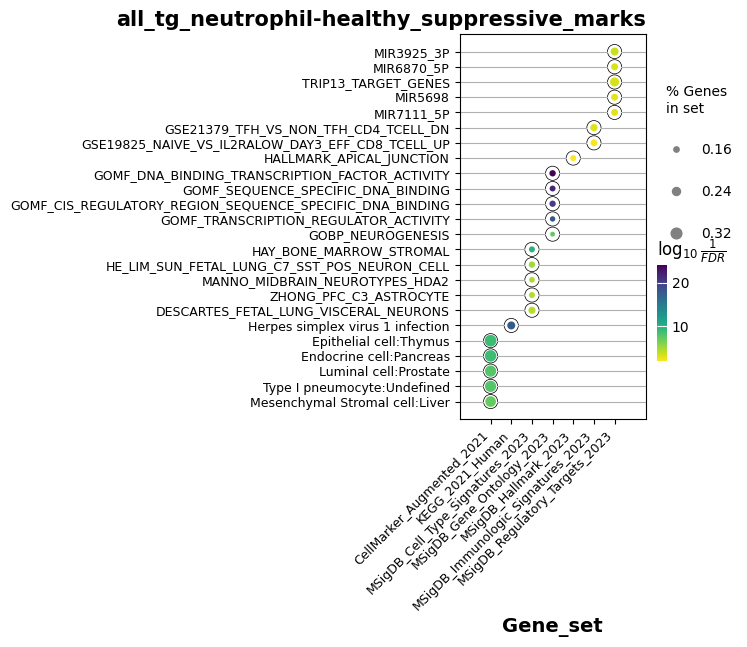

In [34]:
celltypes_all_tg_results_dictionary = {}
for index, row in df_celltype_all_tgs_hgnc.iterrows():
    for tf_type in df_celltype_all_tgs_hgnc.columns:
        genes = list(myfunc.adjust_tfprio_used_TF(row[tf_type]))
        if len(genes)>1:
            enr_bg = gp.enrichr(gene_list=genes,
                        gene_sets=normal_gene_sets,
                        organism='human', # organism argment is ignored because user input a background
                        outdir=None, # don't write to disk
                        )
            enr_bg.results["Gene_set"] = enr_bg.results["Gene_set"].replace(normal_gene_sets_renaming)
            try:
                ax = gp.dotplot(enr_bg.results,
                            column="Adjusted P-value",
                            x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
                            size=4,
                            top_term=5,
                            figsize=(3,5),
                            xticklabels_rot=45, # rotate xtick labels
                            show_ring=True, # set to False to revmove outer ring
                            marker='o',
                            )
                x_axis_size, y_axis_size, title_size = myfunc.enrichr_adjust_axis_title_font_sizes(enr_bg.results)
                ax.tick_params(axis='x', labelsize=x_axis_size)
                ax.tick_params(axis='y', labelsize=y_axis_size)
                ax.set_title("all_tg_"+index+"_"+tf_type+"_celltype", loc="right", fontsize=title_size,fontweight='bold')
                figure_file_name = "ORA_all_TG_"+index+"_"+tf_type+"_celltypes"
                plt.savefig(os.path.join(path_to_figure_folder, figure_file_name), bbox_inches='tight')
                celltypes_all_tg_results_dictionary[index+"_"+tf_type] = enr_bg.results
            except ValueError as ve:
                print("For "+str(index)+"_"+tf_type)
                print(ve)

### Analysis on how big the discussed enriched gene sets are

In [39]:
t_cell_active = celltypes_all_tg_results_dictionary["t-cell-healthy_active_marks"]
set(t_cell_active["Gene_set"])

{'CellMarker_Augmented_2021',
 'KEGG_2021_Human',
 'MSigDB_Cell_Type_Signatures_2023',
 'MSigDB_Gene_Ontology_2023',
 'MSigDB_Hallmark_2023',
 'MSigDB_Immunologic_Signatures_2023',
 'MSigDB_Regulatory_Targets_2023'}

In [41]:
t_cell_active[t_cell_active["Gene_set"]=="MSigDB_Immunologic_Signatures_2023"].sort_values(by=["Adjusted P-value"]).head(20)

Gene_set  \
5604  MSigDB_Immunologic_Signatures_2023   
3947  MSigDB_Immunologic_Signatures_2023   
4382  MSigDB_Immunologic_Signatures_2023   
4378  MSigDB_Immunologic_Signatures_2023   
4890  MSigDB_Immunologic_Signatures_2023   
5702  MSigDB_Immunologic_Signatures_2023   
4920  MSigDB_Immunologic_Signatures_2023   
7665  MSigDB_Immunologic_Signatures_2023   
5131  MSigDB_Immunologic_Signatures_2023   
5844  MSigDB_Immunologic_Signatures_2023   
5762  MSigDB_Immunologic_Signatures_2023   
5253  MSigDB_Immunologic_Signatures_2023   
5084  MSigDB_Immunologic_Signatures_2023   
6200  MSigDB_Immunologic_Signatures_2023   
5698  MSigDB_Immunologic_Signatures_2023   
8449  MSigDB_Immunologic_Signatures_2023   
4380  MSigDB_Immunologic_Signatures_2023   
7670  MSigDB_Immunologic_Signatures_2023   
5252  MSigDB_Immunologic_Signatures_2023   
5757  MSigDB_Immunologic_Signatures_2023   

                                                   Term  Overlap  \
5604         GSE22886_NAIVE_CD4_TCELL_VS_48H_ACT_TH2_DN  162/197   
3947    GSE12845_IGD_NEG_BLOOD_VS_NAIVE_TONSIL_BCELL_UP  158/196   
4382  GSE15930_NAIVE_VS_24H_IN_VITRO_STIM_INFAB_CD8_...  159/199   
4378   GSE15930_NAIVE_VS_24H_IN_VITRO_STIM_CD8_TCELL_DN  159/199   
4890       GSE17974_0H_VS_12H_IN_VITRO_ACT_CD4_TCELL_DN  157/199   
5702  GSE23321_CD8_STEM_CELL_MEMORY_VS_NAIVE_CD8_TCE...  154/195   
4920  GSE17974_CTRL_VS_ACT_IL4_AND_ANTI_IL12_24H_CD4...  156/198   
7665            GSE41867_NAIVE_VS_EFFECTOR_CD8_TCELL_UP  157/200   
5131      GSE19923_WT_VS_HEB_AND_E2A_KO_DP_THYMOCYTE_UP  156/199   
5844  GSE24634_NAIVE_CD4_TCELL_VS_DAY5_IL4_CONV_TREG_DN  156/200   
5762  GSE2405_0H_VS_9H_A_PHAGOCYTOPHILUM_STIM_NEUTRO...  156/200   
5253              GSE21033_CTRL_VS_POLYIC_STIM_DC_3H_UP  153/195   
5084  GSE19825_IL2RALOW_VS_IL2RAHIGH_DAY3_EFF_CD8_TC...  156/200   
6200  GSE2770_UNTREATED_VS_IL12_TREATED_ACT_CD4_TCEL...  156/200   
5698  GSE23321_CD8_STEM_CELL_MEMORY_VS_CENTRAL_MEMOR...  152/194   
8449  GSE9006_HEALTHY_VS_TYPE_1_DIABETES_PBMC_1MONTH...  155/199   
4380  GSE15930_NAIVE_VS_24H_IN_VITRO_STIM_IL12_CD8_T...  155/199   
7670  GSE41978_ID2_KO_VS_ID2_KO_AND_BIM_KO_KLRG1_LOW...  154/198   
5252              GSE21033_CTRL_VS_POLYIC_STIM_DC_3H_DN  154/198   
5757  GSE2405_0H_VS_24H_A_PHAGOCYTOPHILUM_STIM_NEUTR...  155/200   

           P-value  Adjusted P-value  Odds Ratio  Combined Score  \
5604  1.816322e-25      8.849119e-22    5.352881      304.941950   
3947  4.297382e-23      1.046842e-19    4.811874      247.818505   
4382  1.822298e-22      2.219559e-19    4.602861      230.404396   
4378  1.822298e-22      2.219559e-19    4.602861      230.404396   
4890  3.693323e-21      3.598774e-18    4.330034      203.718398   
5702  7.312525e-21      5.089517e-18    4.349199      201.649292   
4920  6.329898e-21      5.089517e-18    4.302215      200.091707   
7665  9.320787e-21      5.676359e-18    4.230218      195.106266   
5131  1.589515e-20      8.604572e-18    4.203039      191.609313   
5844  3.920424e-20      1.364308e-17    4.108322      183.582422   
5762  3.920424e-20      1.364308e-17    4.108322      183.582422   
5253  3.160450e-20      1.364308e-17    4.218782      189.427462   
5084  3.920424e-20      1.364308e-17    4.108322      183.582422   
6200  3.920424e-20      1.364308e-17    4.108322      183.582422   
5698  5.386612e-20      1.749572e-17    4.190979      185.944464   
8449  6.643156e-20      1.903850e-17    4.081760      180.242835   
4380  6.643156e-20      1.903850e-17    4.081760      180.242835   
7670  1.124074e-19      2.882362e-17    4.055203      176.937239   
5252  1.124074e-19      2.882362e-17    4.055203      176.937239   
5757  1.602145e-19      3.716977e-17    3.991791      172.755841   

                                                  Genes  
5604  RBL1;IL4;ELAVL1;SLC25A44;PARK7;CCDC86;EED;ZBTB...  
3947  SLC25A1;FLOT1;AKT3;ORMDL2;YWHAH;ALDOB;NFE2L3;G...  
4382  PAFAH1B2;TGDS;TIMM9;CCNE2;POLR3D;CRCP;RRP9;DTD...  
4378  PAFAH1B2;TG

# ORA TF + TG

In [25]:
df_cell_type_tf_top_k_tg_hgnc = pd.DataFrame(index=df_cell_type_tfs.index, columns=df_cell_type_tfs.columns)
df_cell_type_tf_all_tgs_hgnc = pd.DataFrame(index=df_cell_type_tfs.index, columns=df_cell_type_tfs.columns)
for row in df_cell_type_tfs.index:
    for col in df_cell_type_tfs.columns:
        df_cell_type_tf_top_k_tg_hgnc.at[row, col] = df_cell_type_tfs.at[row, col].union(df_celltype_top_k_tg_hgnc.at[row, col])
        df_cell_type_tf_all_tgs_hgnc.at[row, col] = df_cell_type_tfs.at[row, col].union(df_celltype_all_tgs_hgnc.at[row, col])

In [26]:
df_cell_type_tf_top_k_tg_hgnc.applymap(lambda x: len(set(x)))

active_marks  suppressive_marks
b-cells-healthy                5                  7
macrophage-healthy             6                  2
t-cell-healthy               124                  2
monocyte-healthy              98                  0
neutrophil-healthy            35                 61

## all TGs

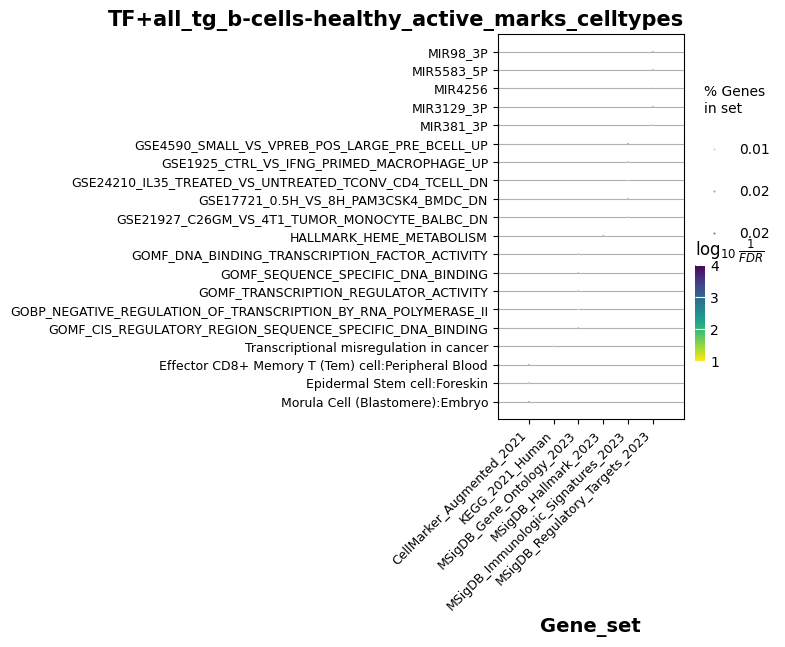

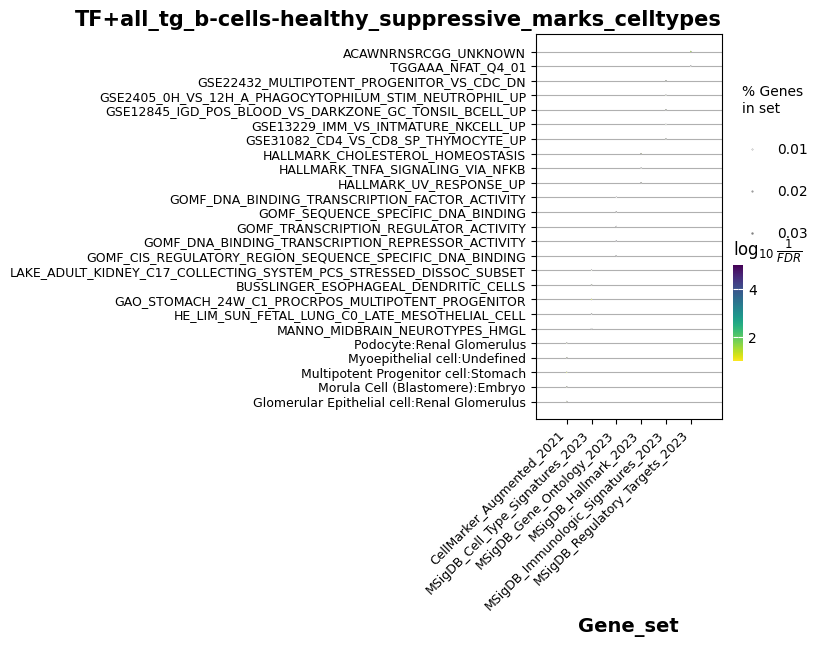

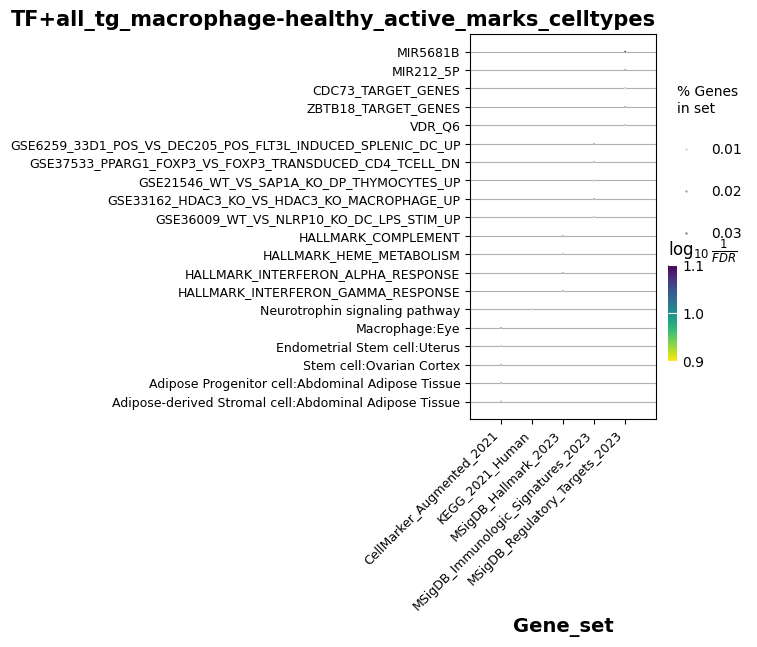

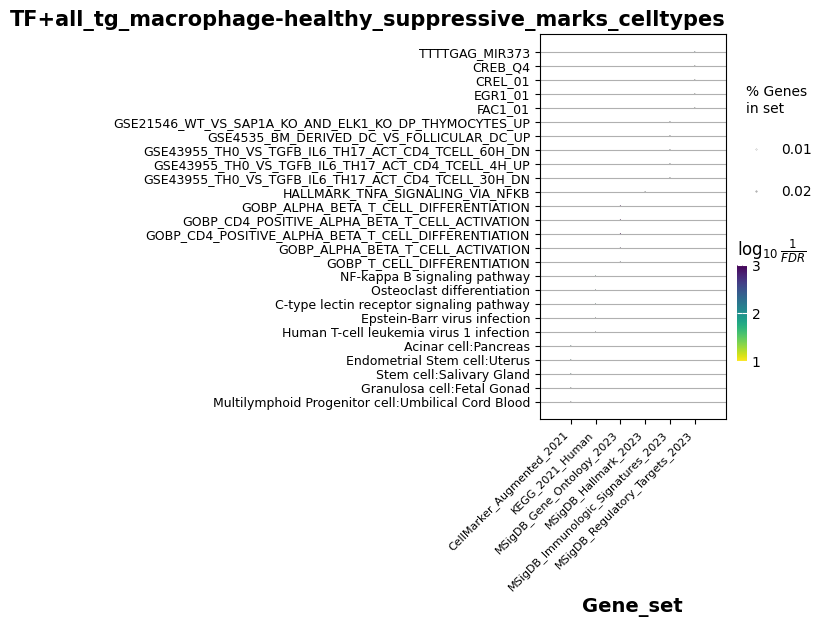

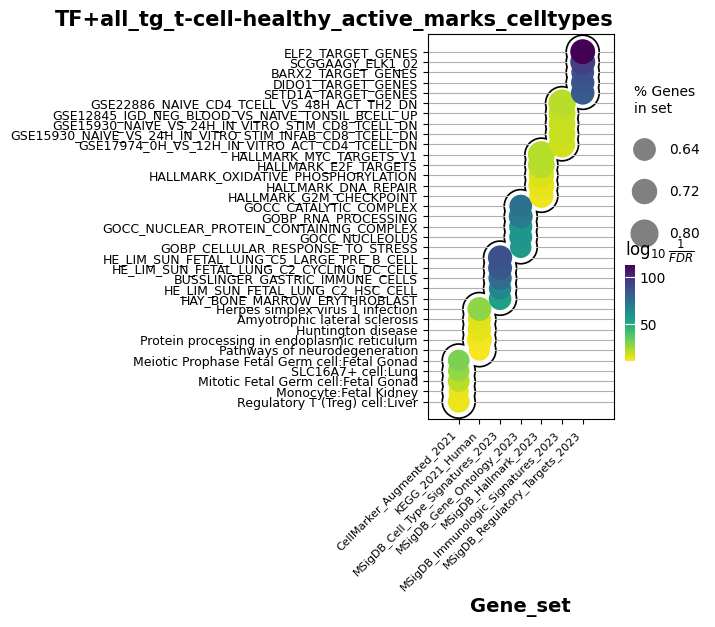

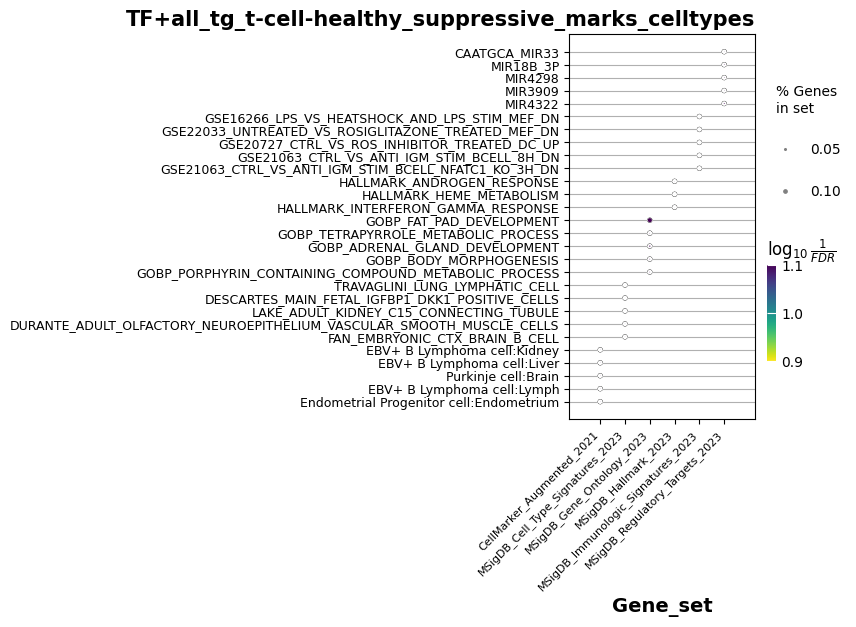

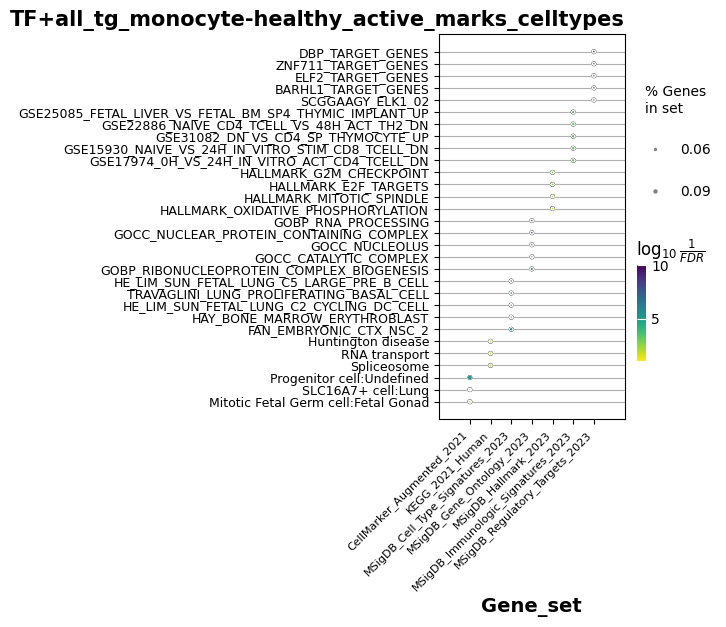

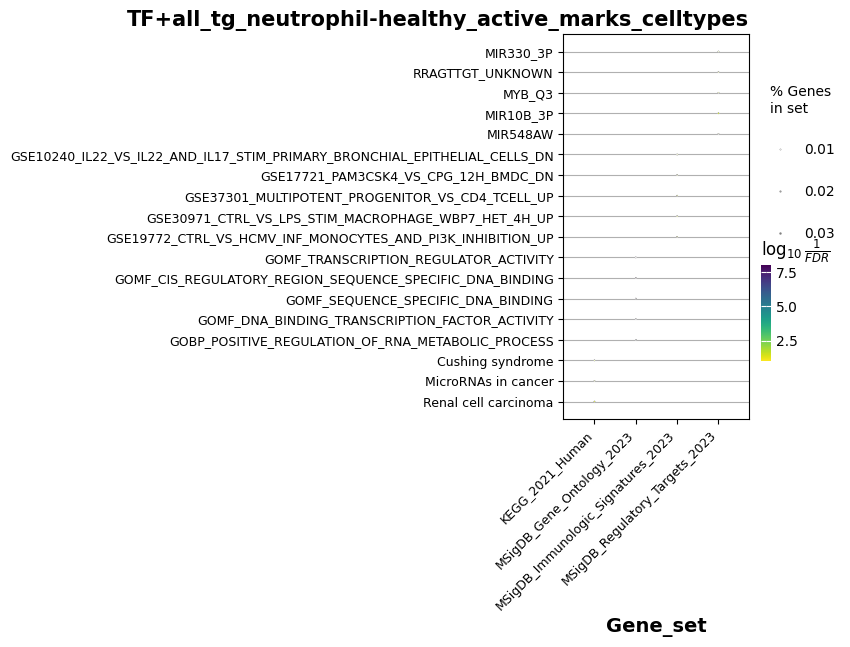

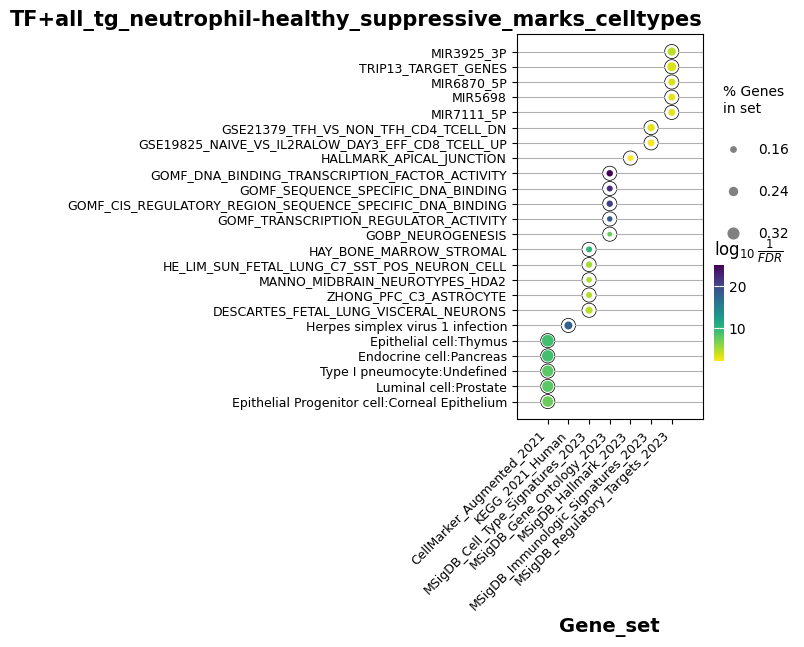

In [30]:
celltypes_TF_all_tg_results_dictionary = {}
for index, row in df_cell_type_tf_all_tgs_hgnc.iterrows():
    for tf_type in df_cell_type_tf_all_tgs_hgnc.columns:
        genes = list(myfunc.adjust_tfprio_used_TF(row[tf_type]))
        if len(genes)>1:
            enr_bg = gp.enrichr(gene_list=genes,
                        gene_sets=normal_gene_sets,
                        organism='human', # organism argment is ignored because user input a background
                        outdir=None, # don't write to disk
                        )
            enr_bg.results["Gene_set"] = enr_bg.results["Gene_set"].replace(normal_gene_sets_renaming)
            try:
                ax = gp.dotplot(enr_bg.results,
                            column="Adjusted P-value",
                            x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
                            size=4,
                            top_term=5,
                            figsize=(3,5),
                            xticklabels_rot=45, # rotate xtick labels
                            show_ring=True, # set to False to revmove outer ring
                            marker='o',
                            )
                x_axis_size, y_axis_size, title_size = myfunc.enrichr_adjust_axis_title_font_sizes(enr_bg.results)
                ax.tick_params(axis='y', labelsize=x_axis_size)
                ax.tick_params(axis='x', labelsize=y_axis_size)
                ax.set_title("TF+all_tg_"+index+"_"+tf_type+"_celltypes", loc="right", fontsize=title_size,fontweight='bold')
                figure_file_name = "ORA_TF_all_TG_"+index+"_"+tf_type+"_celltypes"
                #plt.savefig(os.path.join(path_to_figure_folder, figure_file_name), bbox_inches='tight')
                celltypes_TF_all_tg_results_dictionary[index+"_"+tf_type] = enr_bg.results
            except ValueError as ve:
                print("For "+str(index)+"_"+tf_type)
                print(ve)

## topK TGs

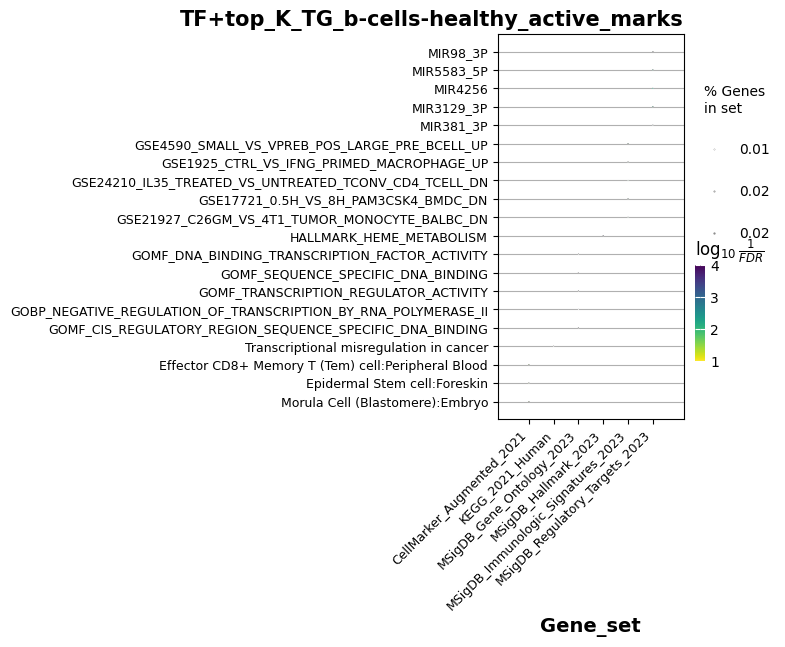

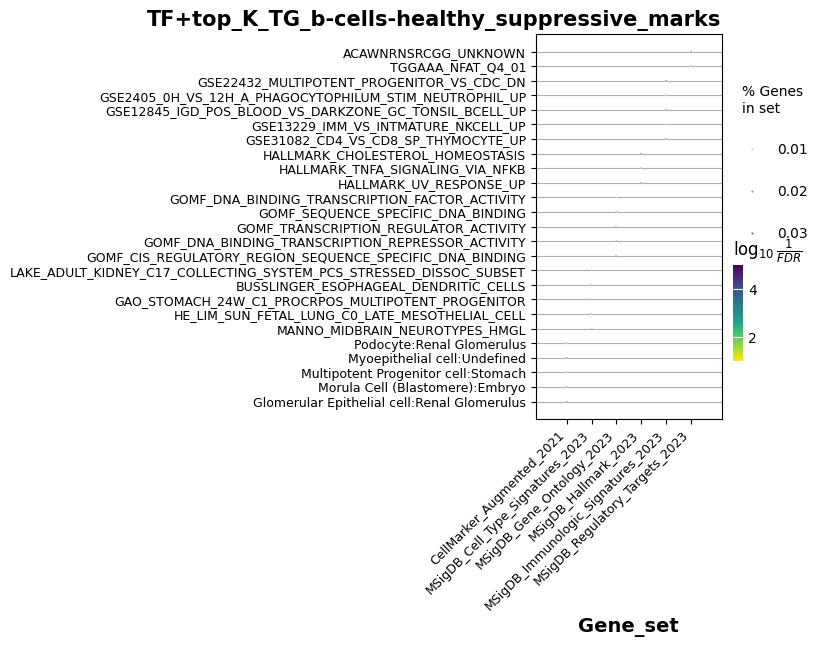

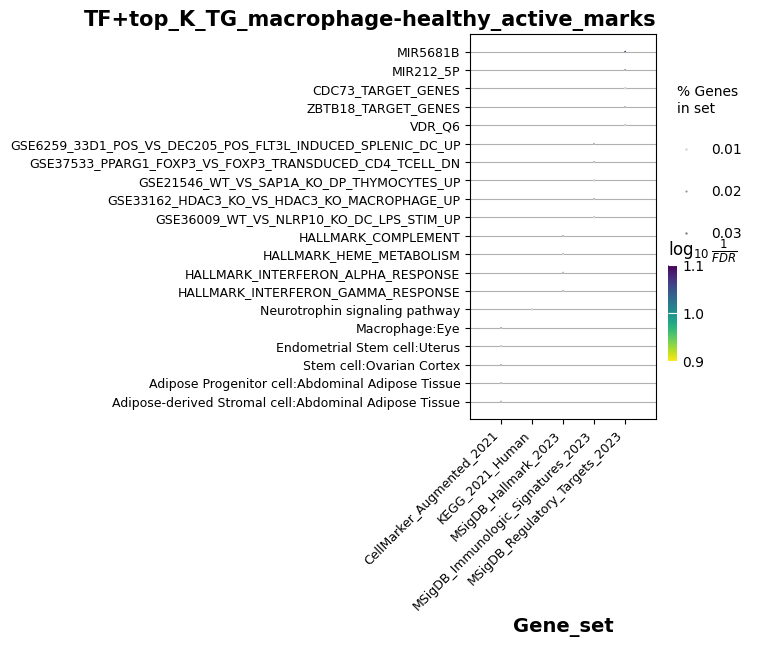

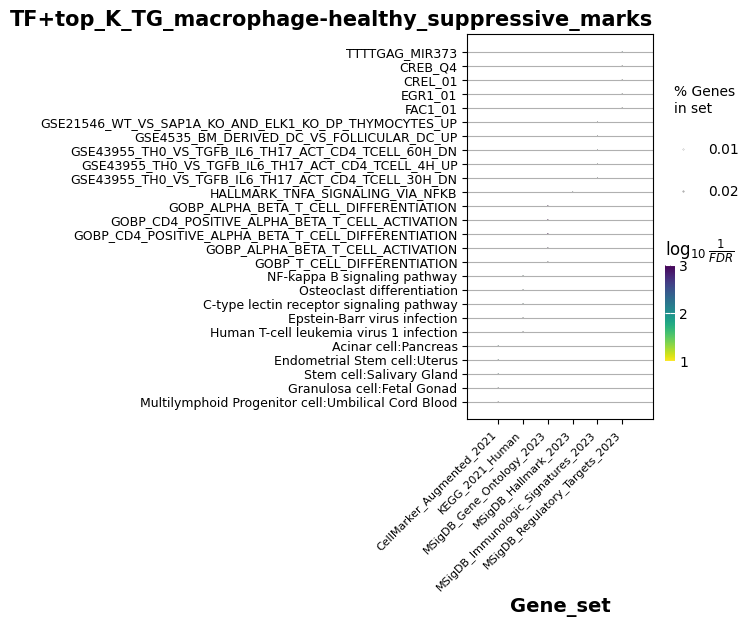

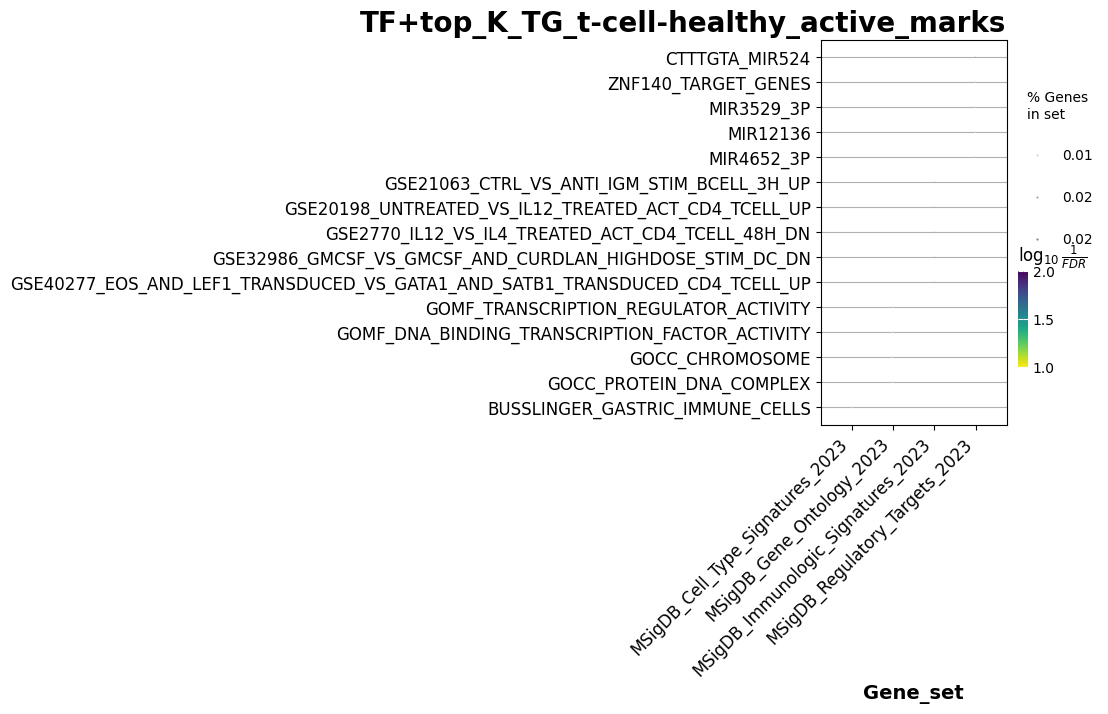

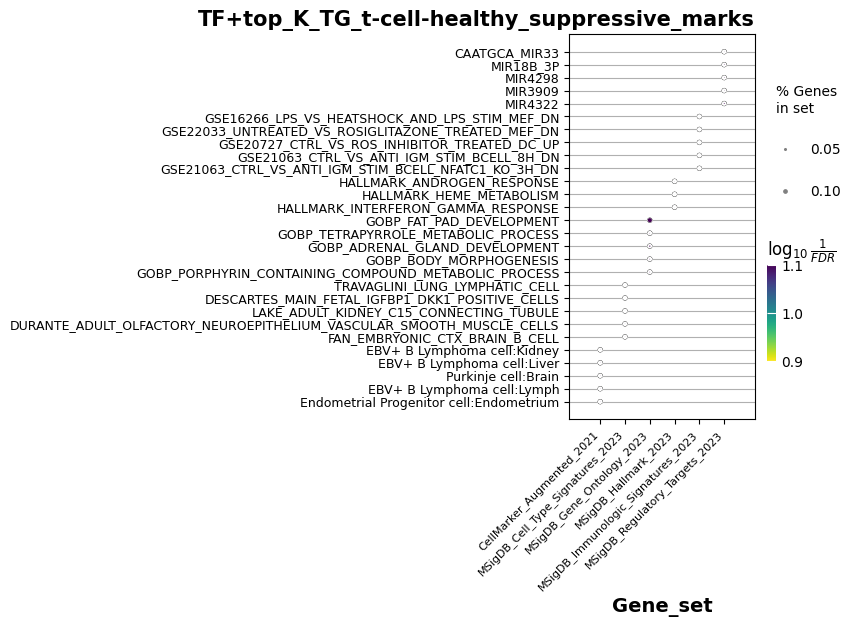

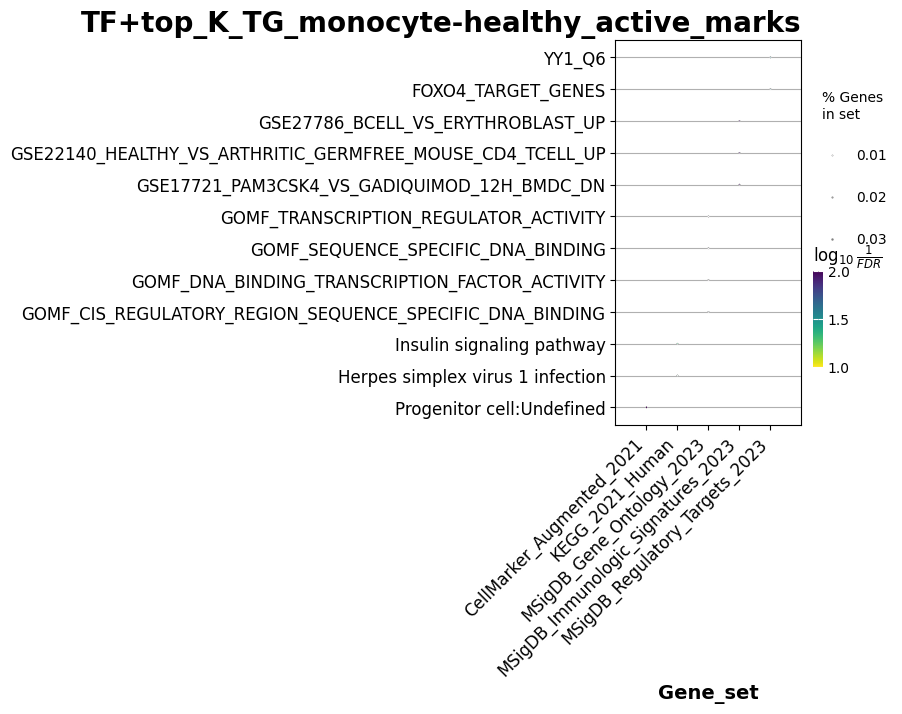

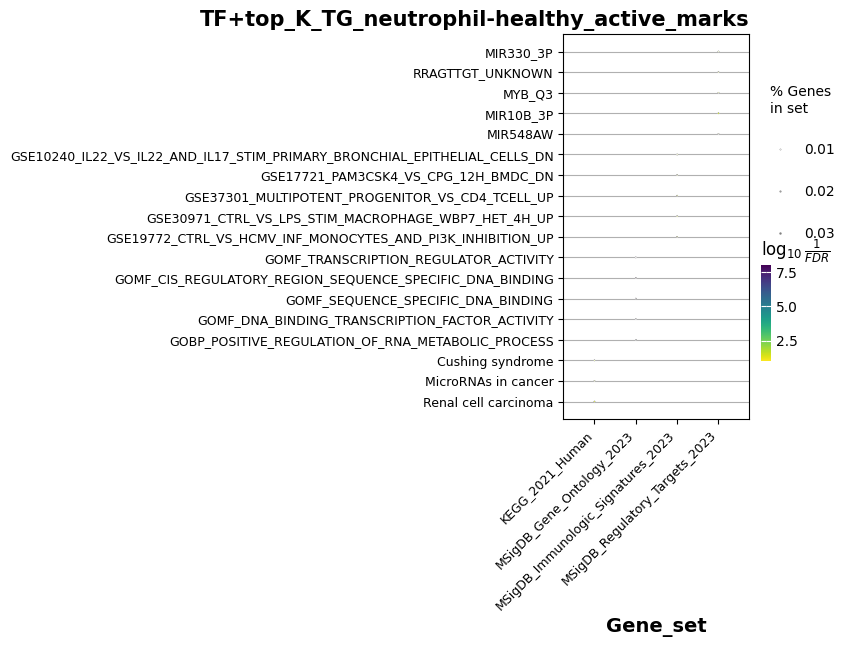

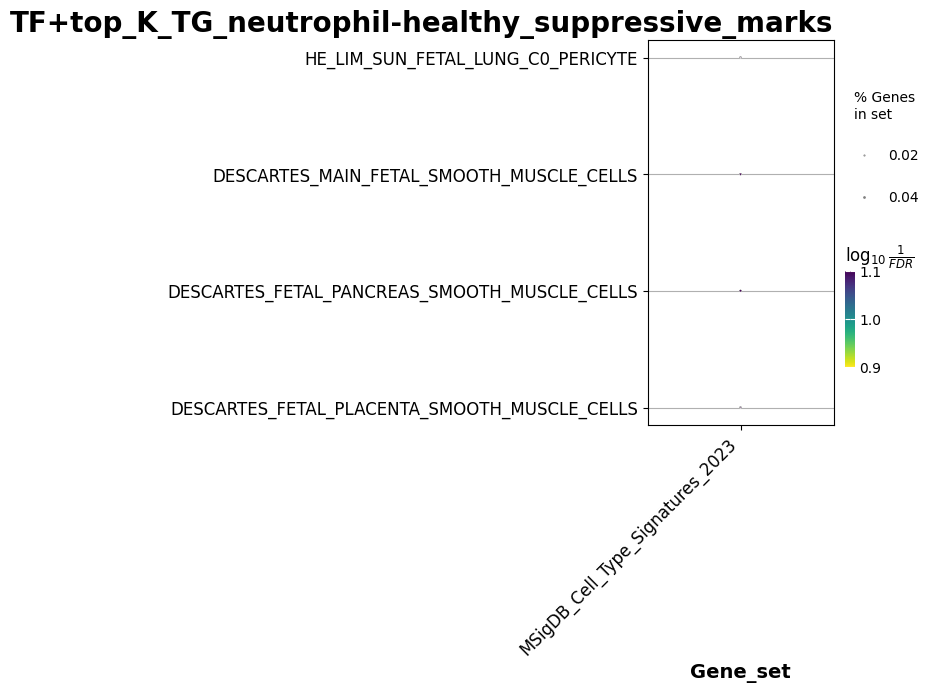

In [31]:
celltypes_TF_top_k_tg_results_dictionary = {}
for index, row in df_cell_type_tf_top_k_tg_hgnc.iterrows():
    for tf_type in df_cell_type_tf_top_k_tg_hgnc.columns:
        genes = list(myfunc.adjust_tfprio_used_TF(row[tf_type]))
        if len(genes)>1:
            enr_bg = gp.enrichr(gene_list=genes,
                        gene_sets=normal_gene_sets,
                        organism='human', # organism argment is ignored because user input a background
                        outdir=None, # don't write to disk
                        )
            enr_bg.results["Gene_set"] = enr_bg.results["Gene_set"].replace(normal_gene_sets_renaming)
            try:
                ax = gp.dotplot(enr_bg.results,
                            column="Adjusted P-value",
                            x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
                            size=4,
                            top_term=5,
                            figsize=(3,5),
                            xticklabels_rot=45, # rotate xtick labels
                            show_ring=True, # set to False to revmove outer ring
                            marker='o',
                            )
                x_axis_size, y_axis_size, title_size = myfunc.enrichr_adjust_axis_title_font_sizes(enr_bg.results)
                ax.tick_params(axis='y', labelsize=x_axis_size)
                ax.tick_params(axis='x', labelsize=y_axis_size)
                ax.set_title("TF+top_K_TG_"+index+"_"+tf_type, loc="right", fontsize=title_size,fontweight='bold')
                figure_file_name = "ORA_TF_top_K_TG_"+index+"_"+tf_type
                #plt.savefig(os.path.join(path_to_figure_folder, figure_file_name), bbox_inches='tight')
                celltypes_TF_top_k_tg_results_dictionary[index+"_"+tf_type] = enr_bg.results
            except ValueError as ve:
                print("For "+str(index)+"_"+tf_type)
                print(ve)

# find TFs that target a big  proportion of all genes
When looking at the target genes of the TFs, as shown in the table below, some TFs for T-cells active markers and for neutrophil supressive markers seem to target a lot of all genes

In [44]:
sliced_tf_df = df_cell_type_tfs[0:1]
sliced_tf_df

active_markers  \
b-cells-healthy  {KLF3, YY1, VEZF1, NR2C1, ZBTB6}   

                                           suppressive_markers  
b-cells-healthy  {SREBF2, ZBED2, NFATC2, NR4A1, ZNF354C, KLF8}

In [45]:
df_cell_type_tfs_all_tgs_sliced = df_cell_type_tfs_all_tgs[0:1]

In [36]:
df_cell_type_tfs_all_tgs.applymap(lambda x: len(x))

active_markers  suppressive_markers
b-cells-healthy                 58                    5
macrophage-healthy              90                    0
t-cell-healthy              356298                    0
monocyte-healthy              7365                    0
neutrophil-healthy             390               231712

In [14]:
df_cell_type_tfs_all_tgs.applymap(lambda x: len(set(x)))

active_markers  suppressive_markers
b-cells-healthy                 55                    1
macrophage-healthy              49                    0
t-cell-healthy               45892                    0
monocyte-healthy              3567                    0
neutrophil-healthy             274                45892

In [12]:
df_cell_type_tfs_all_tgs_new.applymap(lambda x: len(set(x)))

active_markers  suppressive_markers
b-cells-healthy                  0                    1
macrophage-healthy              13                    0
t-cell-healthy               36896                    0
monocyte-healthy               879                    0
neutrophil-healthy              25                16198

In [32]:
#tpm_df.loc[row.name, "TPM_filtered_genes"]
#for 
#tf_dict = df_cell_type_tfs_all_tgs.to_dict("index")
#for comparison, values in tf_dict.items():
#    if any(col for col in df_cell_type_tfs_all_tgs.columns if len(df_cell_type_tfs_all_tgs.loc(comparison, col)>20000)):
#        print(comparison)

tf_tg_dict = df_cell_type_tfs_all_tgs.to_dict("index")
tf_dict = df_cell_type_tfs.to_dict("index")
#df_cell_type_tfs
tf_filtered_tg_dict={}

for comparison, columns in tf_tg_dict.items():
    for hm_markers, tg_list in columns.items():
        if len(tg_list) >= 20000:
            #print(hm_markers)
            #print(comparison)
            tf_list = df_cell_type_tfs.loc[comparison, hm_markers]
            print(len(tf_list))

7
4


In [37]:
df_cell_type_tfs.loc["t-cell-healthy", "active_markers"]

{'KLF7', 'NFATC3', 'SP4', 'STAT3', 'STAT5B', 'ZNF384', 'ZNF554'}

In [50]:
def read_out_master_regulator_tf_old(tf_tgs_df, tf_df, all_comparisons_path, min_num_tg_total = 20000, min_num_tgs_per_tf = 1000, affinity_filter_value=0.05):
    """Reads out the target genes above the set affinity_filter_value. Either using the top_k_genes df from the output folder or the files  from the input folder in 
    org_exbio_tfprio_steps_distributionAnalysis_TopKTargetGenes
    Needs as input 2 dataframes:
    tf_tgs_df should contain the dataframe with all target genes for the TFs of that specific condition
    tf_df should be the dataframe  which was used to create the tf_tgs_df

    """
    tf_tg_dict = tf_tgs_df.to_dict("index")
    tf_dict = tf_df.to_dict("index")
    tf_filtered_tg_dict={}
    dir_list = [path.path for path in os.scandir(all_comparisons_path) if path.is_dir()]
    read_counts = 0
    for comparison, columns in tf_tg_dict.items():
        for hm_markers, tg_list in columns.items():
            if len(tg_list) >= min_num_tg_total:
                tf_filtered_tg_dict[comparison]={}
                tf_filtered_tg_dict[comparison][hm_markers]={}
                tf_list = tf_df.loc[comparison, hm_markers]
                for dir in dir_list:
                    if comparison in dir:
                        comparison_path = os.path.join(all_comparisons_path, dir)
                        gene_base_dir = os.path.join(comparison_path, "output/output/org_exbio_tfprio_steps_distributionAnalysis_TopKTargetGenes/input", comparison)
                        for root, dirs, files in os.walk(gene_base_dir):
                            for tg_matrix in files:
                                if tg_matrix == "dcg.tsv":
                                    continue
                                tg_matrix_path = os.path.join(root, tg_matrix)
                                tg_matrix_df = pd.read_csv(tg_matrix_path,  sep="\t")
                                read_counts += 1
                                #for mode, tf_list in values.items():
                                for tf in tf_list:
                                    new_tgs = tg_matrix_df[tg_matrix_df[tf]>=affinity_filter_value]["Gene"].tolist()
                                    if len(new_tgs) >= min_num_tgs_per_tf:
                                        if tf not in tf_filtered_tg_dict[comparison][hm_markers].keys():
                                            tf_filtered_tg_dict[comparison][hm_markers][tf] = set()
                                        if tf in tg_matrix_df.columns:
                                            tf_filtered_tg_dict[comparison][hm_markers][tf].update(new_tgs)
                                            #tf_filtered_tg_dict[comparison][hm_markers].append([tf, len(new_tgs)])
    master_regulator_tf_df = flatten_master_regulator_dict(tf_filtered_tg_dict)
    print(read_counts)
    return master_regulator_tf_df

In [43]:
def read_out_master_regulator_tf(tf_tgs_df, tf_df, all_comparisons_path, min_num_tg_total = 20000, min_num_tgs_per_tf = 1000, affinity_filter_value=0.05):
    """Reads out the target genes above the set affinity_filter_value. Either using the top_k_genes df from the output folder or the files  from the input folder in 
    org_exbio_tfprio_steps_distributionAnalysis_TopKTargetGenes
    Needs as input 2 dataframes:
    tf_tgs_df should contain the dataframe with all target genes for the TFs of that specific condition
    tf_df should be the dataframe  which was used to create the tf_tgs_df

    """
    tf_tg_dict = tf_tgs_df.to_dict("index")
    tf_dict = tf_df.to_dict("index")
    tf_filtered_tg_dict={}
    dir_list = [path.path for path in os.scandir(all_comparisons_path) if path.is_dir()]
    read_counts = 0
    for comparison, columns in tf_tg_dict.items():
        for dir in dir_list:
            if comparison in dir:
                comparison_path = os.path.join(all_comparisons_path, dir)
                gene_base_dir = os.path.join(comparison_path, "output/output/org_exbio_tfprio_steps_distributionAnalysis_TopKTargetGenes/input", comparison)
                for hm_markers, tg_list in columns.items():
                    if len(tg_list) >= min_num_tg_total:
                        tf_filtered_tg_dict[comparison]={}
                        tf_filtered_tg_dict[comparison][hm_markers]={}
                        tf_list = tf_df.loc[comparison, hm_markers]
                        for dir in dir_list:
                            if comparison in dir:
                                comparison_path = os.path.join(all_comparisons_path, dir)
                                gene_base_dir = os.path.join(comparison_path, "output/output/org_exbio_tfprio_steps_distributionAnalysis_TopKTargetGenes/input", comparison)
                                for root, dirs, files in os.walk(gene_base_dir):
                                    for tg_matrix in files:
                                        if tg_matrix == "dcg.tsv":
                                            continue
                                        tg_matrix_path = os.path.join(root, tg_matrix)
                                        tg_matrix_df = pd.read_csv(tg_matrix_path,  sep="\t")
                                        read_counts += 1
                                        #for mode, tf_list in values.items():
                                        for tf in tf_list:
                                            new_tgs = tg_matrix_df[tg_matrix_df[tf]>=affinity_filter_value]["Gene"].tolist()
                                            if len(new_tgs) >= min_num_tgs_per_tf:
                                                if tf not in tf_filtered_tg_dict[comparison][hm_markers].keys():
                                                    tf_filtered_tg_dict[comparison][hm_markers][tf] = set()
                                                if tf in tg_matrix_df.columns:
                                                    tf_filtered_tg_dict[comparison][hm_markers][tf].update(new_tgs)
                                                    #tf_filtered_tg_dict[comparison][hm_markers].append([tf, len(new_tgs)])
    master_regulator_tf_df = flatten_master_regulator_dict(tf_filtered_tg_dict)
    print(read_counts)
    return master_regulator_tf_df

In [57]:
df_cell_type_tfs

active_markers  \
b-cells-healthy                      {NR2C1, KLF3, VEZF1, ZBTB6, YY1}   
macrophage-healthy                              {FOXO3, PRDM4, VEZF1}   
t-cell-healthy      {KLF7, ZNF384, SP4, ZNF554, STAT5B, STAT3, NFA...   
monocyte-healthy         {KLF6, ZNF121, ZNF770, SREBF1, NFATC3, IRF2}   
neutrophil-healthy  {CBFB, KLF6, MAFK, ZNF18, ZBTB48, ZBTB26, ELK4...   

                                              suppressive_markers  
b-cells-healthy     {SREBF2, ZBED2, ZNF354C, KLF8, NR4A1, NFATC2}  
macrophage-healthy                     {CBFB, ARID5B, RELB, JUND}  
t-cell-healthy                                   {ARID5B, NFE2L1}  
monocyte-healthy                                               {}  
neutrophil-healthy                 {FOXP1, NFE2L1, FOXJ3, ZNF384}

In [47]:
def read_out_master_regulator_tf_new(tf_tgs_df, tf_df, all_comparisons_path, min_num_tg_total = 20000, min_num_tgs_per_tf = 1000, affinity_filter_value=0.05):
    """Reads out the target genes above the set affinity_filter_value. Either using the top_k_genes df from the output folder or the files  from the input folder in 
    org_exbio_tfprio_steps_distributionAnalysis_TopKTargetGenes
    Needs as input 2 dataframes:
    tf_tgs_df should contain the dataframe with all target genes for the TFs of that specific condition
    tf_df should be the dataframe  which was used to create the tf_tgs_df

    """
    tf_tg_dict = tf_tgs_df.to_dict("index")
    tf_filtered_tg_dict={}
    dir_list = [path.path for path in os.scandir(all_comparisons_path) if path.is_dir()]
    read_counts = 0
    for comparison, columns in tf_tg_dict.items():
        for dir in dir_list:
            if comparison in dir:
                comparison_path = os.path.join(all_comparisons_path, dir)
                gene_base_dir = os.path.join(comparison_path, "output/output/org_exbio_tfprio_steps_distributionAnalysis_TopKTargetGenes/input", comparison)
                for root, dirs, files in os.walk(gene_base_dir):
                    for tg_matrix in files:
                        if tg_matrix == "dcg.tsv":
                            continue
                        tg_matrix_path = os.path.join(root, tg_matrix)
                        tg_matrix_df = pd.read_csv(tg_matrix_path,  sep="\t")
                        read_counts += 1
                        for hm_markers, tg_list in columns.items():
                            if len(tg_list) >= min_num_tg_total:
                                tf_filtered_tg_dict[comparison]={}
                                tf_filtered_tg_dict[comparison][hm_markers]={}
                                tf_list = tf_df.loc[comparison, hm_markers]
                                for tf in tf_list:
                                    new_tgs = tg_matrix_df[tg_matrix_df[tf]>=affinity_filter_value]["Gene"].tolist()
                                    if len(new_tgs) >= min_num_tgs_per_tf:
                                        if tf not in tf_filtered_tg_dict[comparison][hm_markers].keys():
                                            tf_filtered_tg_dict[comparison][hm_markers][tf] = set()
                                        if tf in tg_matrix_df.columns:
                                            tf_filtered_tg_dict[comparison][hm_markers][tf].update(new_tgs)


    master_regulator_tf_df = flatten_master_regulator_dict(tf_filtered_tg_dict)
    print(read_counts)
    return master_regulator_tf_df

In [39]:
def flatten_master_regulator_dict(tf_dict):
    # List to store flattened data
    flattened_data = []

    # Recursive function to flatten the nested dictionary
    def flatten(d, level1=None, level2=None):
        for key, value in d.items():
            if isinstance(value, dict):
                if level1 is None:
                    flatten(value, key)
                elif level2 is None:
                    flatten(value, level1, key)
                else:
                    flatten(value, level1, level2, key)
            else:
                # Append the flattened data to the list
                flattened_data.append({
                    "comparison": level1,
                    "markers": level2,
                    "tf": key,
                    "target_strings": list(value)
                })

    # Start flattening from the top level
    flatten(tf_dict)

    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(flattened_data)
    return df

In [54]:
sliced_tf_df = df_cell_type_tfs[1:3]

df_cell_type_tfs_all_tgs_sliced = df_cell_type_tfs_all_tgs[1:3]
df_cell_type_tfs_all_tgs_sliced

active_markers  \
macrophage-healthy  [ENSG00000068079, ENSG00000108828, ENSG0000010...   
t-cell-healthy      [ENSG00000242834, ENSG00000242837, ENSG0000022...   

                   suppressive_markers  
macrophage-healthy                  []  
t-cell-healthy                      []

In [48]:
test_dict2 = read_out_master_regulator_tf_new(df_cell_type_tfs_all_tgs_sliced, sliced_tf_df, path_to_main_comparison_dir, min_num_tg_total=1, min_num_tgs_per_tf=1)

25


In [56]:
test_dict2 = read_out_master_regulator_tf_new(df_cell_type_tfs_all_tgs_sliced, sliced_tf_df, path_to_main_comparison_dir, min_num_tg_total=1, min_num_tgs_per_tf=1)

49


In [55]:
test_dict3 = read_out_master_regulator_tf_old(df_cell_type_tfs_all_tgs_sliced, sliced_tf_df, path_to_main_comparison_dir, min_num_tg_total=1, min_num_tgs_per_tf=1)

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [25]:
sliced_tf_df

active_markers         suppressive_markers
macrophage-healthy  {FOXO3, PRDM4, VEZF1}  {ARID5B, CBFB, JUND, RELB}

In [23]:
test_dict

{'macrophage-healthy': {'active_markers': {'FOXO3': set(),
   'PRDM4': set(),
   'VEZF1': {'ENSG00000037965',
    'ENSG00000068079',
    'ENSG00000108828',
    'ENSG00000108830',
    'ENSG00000172789',
    'ENSG00000175309',
    'ENSG00000198353',
    'ENSG00000207571',
    'ENSG00000224612',
    'ENSG00000226338',
    'ENSG00000245311',
    'ENSG00000260597',
    'ENSG00000273046'}}}}

In [35]:
test_df = flatten_nested_dict(test_dict)
test_df

comparison         markers     tf  \
0  macrophage-healthy  active_markers  FOXO3   
1  macrophage-healthy  active_markers  PRDM4   
2  macrophage-healthy  active_markers  VEZF1   

                                      target_strings  
0                                                 []  
1                                                 []  
2  [ENSG00000245311, ENSG00000172789, ENSG0000027...

In [40]:
flatten_nested_dict(test_dict2)

comparison         markers     tf  \
0  macrophage-healthy  active_markers  VEZF1   

                                      target_strings  
0  [ENSG00000245311, ENSG00000172789, ENSG0000027...

In [45]:
def flatten_master_regulator_dict(nested_dict):
    # List to store flattened data
    flattened_data = []

    # Recursive function to flatten the nested dictionary
    def flatten(d, level1=None, level2=None):
        for key, value in d.items():
            if isinstance(value, dict):
                if level1 is None:
                    flatten(value, key)
                elif level2 is None:
                    flatten(value, level1, key)
                else:
                    flatten(value, level1, level2, key)
            else:
                # Append the flattened data to the list
                flattened_data.append({
                    "comparison": level1,
                    "markers": level2,
                    "tf": key,
                    "target_strings": list(value)
                })

    # Start flattening from the top level
    flatten(nested_dict)

    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(flattened_data)
    return df

In [30]:
def flatten_nested_dict(nested_dict):
    # Initialize a dictionary to store flattened data
    flattened_data = defaultdict(lambda: {"target_strings": []})

    # Recursive function to flatten the nested dictionary
    def flatten(d, level1=None, level2=None, level3=None):
        for key, value in d.items():
            if isinstance(value, dict):
                if level1 is None:
                    flatten(value, key)
                elif level2 is None:
                    flatten(value, level1, key)
                elif level3 is None:
                    flatten(value, level1, level2, key)
                else:
                    flatten(value, level1, level2, level3, key)
            else:
                # Append each item to the flattened_data dictionary
                flattened_data[(level1, level2, level3, key)]["target_strings"].extend(value)

    # Start flattening from the top level
    flatten(nested_dict)

    # Convert flattened data to a DataFrame
    df_data = [{"celltype": k[0], "marker": k[1], "level3": k[2], "level4": k[3], "target_strings": v["target_strings"]} for k, v in flattened_data.items()]
    df = pd.DataFrame(df_data)
    return df

In [47]:
test_path = os.path.join("test", "output/output/org_exbio_tfprio_steps_distributionAnalysis_TopKTargetGenes/input", "b-cells-healthy")
test_path

'test/output/output/org_exbio_tfprio_steps_distributionAnalysis_TopKTargetGenes/input/b-cells-healthy'

In [15]:
test_list = list()
test_list.append(["APX4",  6000])
test_list

[['APX4', 6000]]

In [26]:
nested_dict = {
    'level1_A': {
        'level2_A': {
            'level3_A': {
                'level4_A': {'target_string1', 'target_string3', 'target_string7'},
                'level4_B': {'target_string2', 'target_string4'}
            },
            'level3_B': {
                'level4_C': {'target_string5'}
            }
        },
        'level2_B': {
            'level3_C': {
                'level4_D': {'target_string6', 'target_string8'}
            }
        }
    },
    'level1_B': {
        'level2_C': {
            'level3_D': {
                'level4_E': {'target_string9'}
            }
        }
    }
}

def flatten_nested_dict(nested_dict):
    # Initialize a list to store flattened data
    flattened_data = []

    # Recursive function to flatten the nested dictionary
    def flatten(d, level1=None, level2=None, level3=None):
        for key, value in d.items():
            if isinstance(value, dict):
                if level1 is None:
                    flatten(value, key)
                elif level2 is None:
                    flatten(value, level1, key)
                elif level3 is None:
                    flatten(value, level1, level2, key)
                else:
                    flatten(value, level1, level2, level3, key)
            else:
                # Append each item to the flattened_data list
                for item in value:
                    flattened_data.append([level1, level2, level3, key, item])

    # Start flattening from the top level
    flatten(nested_dict)

    # Convert flattened data to a DataFrame
    df = pd.DataFrame(flattened_data, columns=['level1', 'level2', 'level3', 'level4', 'target_strings'])
    return df

# Create the DataFrame from the nested dictionary
df = flatten_nested_dict(nested_dict)

# Display the DataFrame
print(df)

     level1    level2    level3    level4  target_strings
0  level1_A  level2_A  level3_A  level4_A  target_string7
1  level1_A  level2_A  level3_A  level4_A  target_string3
2  level1_A  level2_A  level3_A  level4_A  target_string1
3  level1_A  level2_A  level3_A  level4_B  target_string2
4  level1_A  level2_A  level3_A  level4_B  target_string4
5  level1_A  level2_A  level3_B  level4_C  target_string5
6  level1_A  level2_B  level3_C  level4_D  target_string8
7  level1_A  level2_B  level3_C  level4_D  target_string6
8  level1_B  level2_C  level3_D  level4_E  target_string9


In [36]:

def flatten_nested_dict(nested_dict):
    # Initialize a dictionary to store flattened data
    flattened_data = defaultdict(lambda: {"target_strings": []})

    # Recursive function to flatten the nested dictionary
    def flatten(d, level1=None, level2=None, level3=None):
        for key, value in d.items():
            if isinstance(value, dict):
                if level1 is None:
                    flatten(value, key)
                elif level2 is None:
                    flatten(value, level1, key)
                elif level3 is None:
                    flatten(value, level1, level2, key)
                else:
                    flatten(value, level1, level2, level3, key)
            else:
                # Append each item to the flattened_data dictionary
                flattened_data[(level1, level2, level3, key)]["target_strings"].extend(value)

    # Start flattening from the top level
    flatten(nested_dict)

    # Convert flattened data to a DataFrame
    df_data = [{"celltype": k[0], "marker": k[1], "level3": k[2], "level4": k[3], "target_strings": v["target_strings"]} for k, v in flattened_data.items()]
    df = pd.DataFrame(df_data)
    return df

In [38]:
def flatten_nested_dict(nested_dict):
    # List to store flattened data
    flattened_data = []

    # Recursive function to flatten the nested dictionary
    def flatten(d, level1=None, level2=None):
        for key, value in d.items():
            if isinstance(value, dict):
                if level1 is None:
                    flatten(value, key)
                elif level2 is None:
                    flatten(value, level1, key)
                else:
                    flatten(value, level1, level2, key)
            else:
                # Append the flattened data to the list
                flattened_data.append({
                    "level1": level1,
                    "level2": level2,
                    "level3": key,
                    "target_strings": list(value)
                })

    # Start flattening from the top level
    flatten(nested_dict)

    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(flattened_data)
    return df

# searching for known relevant TGs

In [28]:
df_cell_type_tfs_all_tgs_0001 = pd.DataFrame.from_dict(myfunc.read_out_filtered_target_genes_dict(df_cell_type_tfs, path_to_main_comparison_dir, modus = "all_genes",  affinity_filter_value = 0.001), orient="index")

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

## healthy cell types